In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files

# Upload files
uploaded = files.upload()

Saving RA302APR2025043166009600059PSANSTUC00GTDF.jpg to RA302APR2025043166009600059PSANSTUC00GTDF.jpg
Saving RA303APR2025043180010100063PSANSTUC00GTDF.jpg to RA303APR2025043180010100063PSANSTUC00GTDF.jpg
Saving RA303APR2025043180010100064PSANSTUC00GTDF.jpg to RA303APR2025043180010100064PSANSTUC00GTDF.jpg
Saving RA315MAR2025042910010200064PSANSTUC00GTDF.jpg to RA315MAR2025042910010200064PSANSTUC00GTDF.jpg


In [ ]:
from google.colab import files

# Upload files
uploaded = files.upload()


Saving RAF30DEC2021026278010300066SSANSTUC00GTDA.jpg to RAF30DEC2021026278010300066SSANSTUC00GTDA.jpg


In [ ]:
!pip install tensorflow matplotlib


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

def load_image(image_path, resize_shape=(512, 512)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, resize_shape)
    return img

def pseudo_ndvi(img):
    red = img[:, :, 0].astype(float)
    green = img[:, :, 1].astype(float)
    ndvi = (green - red) / (green + red + 1e-5)
    return ndvi

def generate_vegetation_mask(ndvi):
    mask = np.zeros_like(ndvi, dtype=np.uint8)
    mask[ndvi > 0.3] = 0      # Forest
    mask[(ndvi > 0.15) & (ndvi <= 0.3)] = 1   # Shrubs
    mask[(ndvi > 0.05) & (ndvi <= 0.15)] = 2  # Grassland
    mask[ndvi <= 0.05] = 3    # Non-vegetation
    return mask

def create_patches(img, mask, patch_size=128):
    img_patches = []
    mask_patches = []
    for i in range(0, img.shape[0] - patch_size + 1, patch_size):
        for j in range(0, img.shape[1] - patch_size + 1, patch_size):
            img_patch = img[i:i+patch_size, j:j+patch_size]
            mask_patch = mask[i:i+patch_size, j:j+patch_size]
            img_patches.append(img_patch)
            mask_patches.append(mask_patch)
    return np.array(img_patches), np.array(mask_patches)

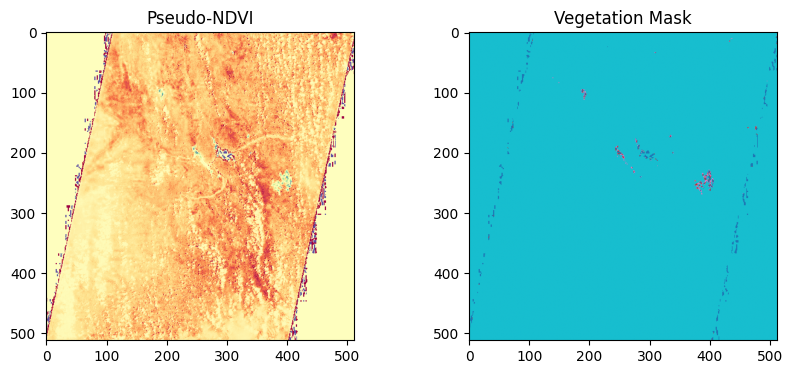

In [ ]:
image_path = 'RA303APR2025043180010100063PSANSTUC00GTDF.jpg'  # Change as needed
img = load_image(image_path)
ndvi = pseudo_ndvi(img)
mask = generate_vegetation_mask(ndvi)

# Visualize
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(ndvi, cmap='Spectral')
plt.title('Pseudo-NDVI')
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='tab10')
plt.title('Vegetation Mask')
plt.show()

# Create Patches
img_patches, mask_patches = create_patches(img, mask)
X = np.array(img_patches) / 255.0
y = to_categorical(mask_patches, num_classes=4)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

def build_unet(input_shape=(128, 128, 3), num_classes=4):
    inputs = Input(input_shape)
    c1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D()(c1)
    c2 = Conv2D(64, 3, activation='relu', padding='same')(p1)
    p2 = MaxPooling2D()(c2)
    b = Conv2D(128, 3, activation='relu', padding='same')(p2)
    u1 = Conv2DTranspose(64, 2, strides=2, padding='same')(b)
    m1 = concatenate([u1, c2])
    c3 = Conv2D(64, 3, activation='relu', padding='same')(m1)
    u2 = Conv2DTranspose(32, 2, strides=2, padding='same')(c3)
    m2 = concatenate([u2, c1])
    c4 = Conv2D(32, 3, activation='relu', padding='same')(m2)
    output = Conv2D(num_classes, 1, activation='softmax')(c4)
    model = Model(inputs, output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_unet()
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=16)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.0378 - loss: 1.3933 - val_accuracy: 0.9146 - val_loss: 1.3627
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8863 - loss: 1.3613 - val_accuracy: 0.9953 - val_loss: 1.3322
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9883 - loss: 1.3266 - val_accuracy: 0.9975 - val_loss: 1.2887
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9903 - loss: 1.2781 - val_accuracy: 0.9975 - val_loss: 1.2215
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9904 - loss: 1.2045 - val_accuracy: 0.9975 - val_loss: 1.1170
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9904 - loss: 1.0922 - val_accuracy: 0.9975 - val_loss: 0.9582
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.9904 - loss: 0.9276 - val_accuracy: 0.9975 - val_loss: 0.7372
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9904 - loss: 0.7131 - val_accuracy: 0.9975 - val_loss: 0.4767
Epoch 9/10
1/1 ━

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step


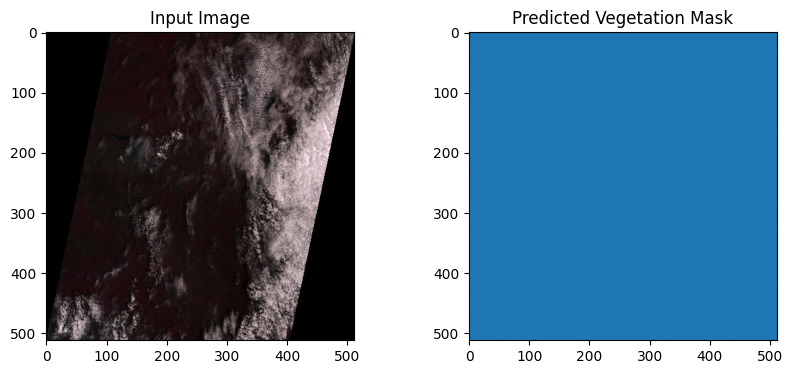

In [ ]:
def predict_image(img, model):
    ndvi = pseudo_ndvi(img)
    mask = generate_vegetation_mask(ndvi)
    patches, _ = create_patches(img, mask)
    patches = patches / 255.0
    predictions = model.predict(patches)
    pred_masks = np.argmax(predictions, axis=-1)

    # Reconstruct full image mask
    h, w = img.shape[:2]
    full_pred = np.zeros((h, w), dtype=np.uint8)
    patch_size = 128
    idx = 0
    for i in range(0, h - patch_size + 1, patch_size):
        for j in range(0, w - patch_size + 1, patch_size):
            full_pred[i:i+patch_size, j:j+patch_size] = pred_masks[idx]
            idx += 1

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.subplot(1, 2, 2)
    plt.imshow(full_pred, cmap='tab10')
    plt.title("Predicted Vegetation Mask")
    plt.show()

    return full_pred

# Predict on another image
test_img = load_image('RA302APR2025043166009600059PSANSTUC00GTDF.jpg')
_ = predict_image(test_img, model)


In [ ]:
def evaluate_image(test_img_path, model):
    img = load_image(test_img_path)
    ndvi = pseudo_ndvi(img)
    true_mask = generate_vegetation_mask(ndvi)

    pred_mask = predict_image(img, model)

    # Resize to original for fair comparison
    if pred_mask.shape != true_mask.shape:
        true_mask = cv2.resize(true_mask, (pred_mask.shape[1], pred_mask.shape[0]), interpolation=cv2.INTER_NEAREST)

    acc = np.sum(pred_mask == true_mask) / (true_mask.shape[0] * true_mask.shape[1])
    print(f"🟢 Accuracy for {test_img_path}: {acc * 100:.2f}%")

    return acc


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 610ms/step - accuracy: 0.7198 - loss: 1.1244 - val_accuracy: 0.9764 - val_loss: 0.3299
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 615ms/step - accuracy: 0.9547 - loss: 0.4029 - val_accuracy: 0.9764 - val_loss: 0.1832
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 485ms/step - accuracy: 0.9626 - loss: 0.2120 - val_accuracy: 0.9764 - val_loss: 0.1305
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 551ms/step - accuracy: 0.9467 - loss: 0.2071 - val_accuracy: 0.9764 - val_loss: 0.1077
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 613ms/step - accuracy: 0.9564 - loss: 0.1598 - val_accuracy: 0.9764 - val_loss: 0.0947
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 461ms/step - accuracy: 0.9636 - loss: 0.1164 - val_accuracy: 0.9764 - val_loss: 0.0923
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 465ms/step - accuracy: 0.9490 - loss: 0.1321 - val_accuracy: 0.9764 - val_loss: 0.0752
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 535ms/step - accuracy: 0.9528 - loss: 0.1187 - val_accura

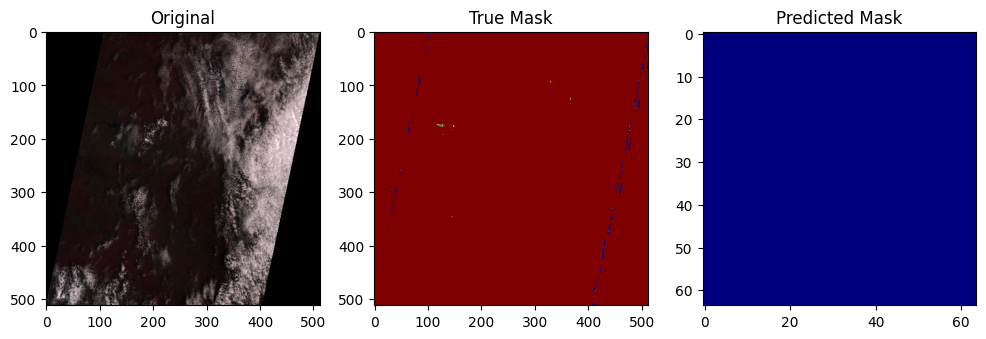

🟢 Accuracy: 99.41%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


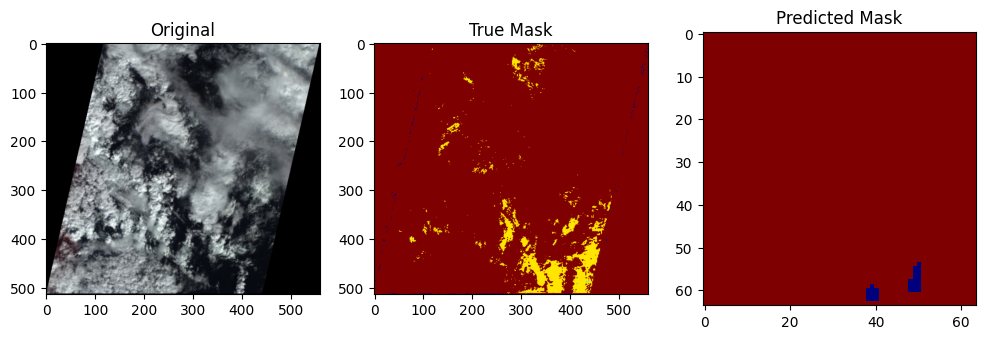

🟢 Accuracy: 95.97%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


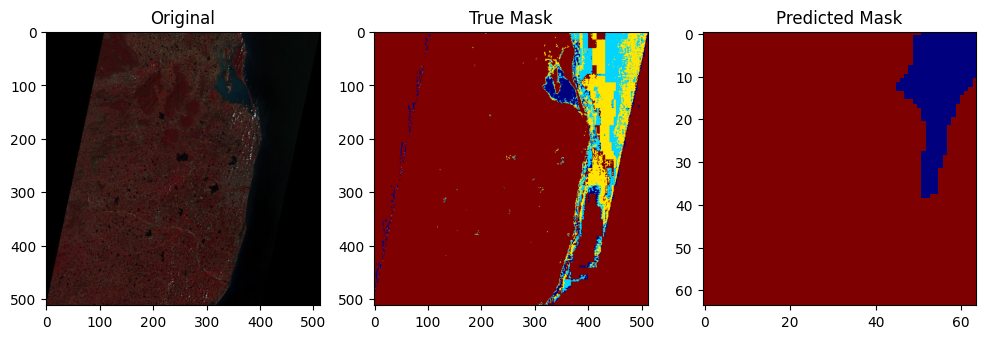

🟢 Accuracy: 89.48%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


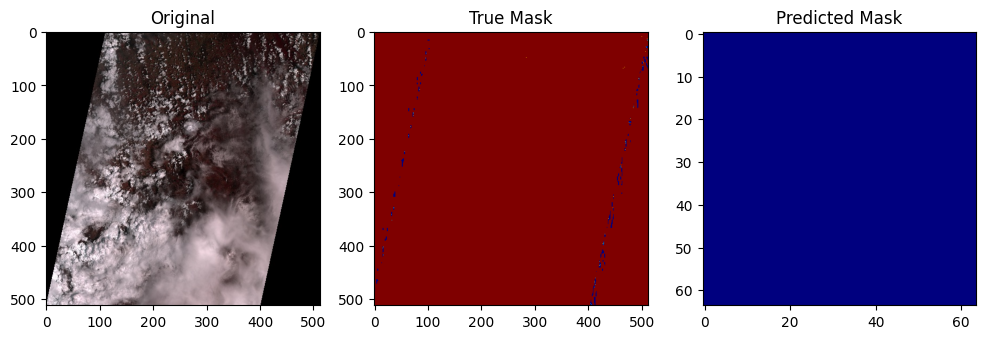

🟢 Accuracy: 99.24%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


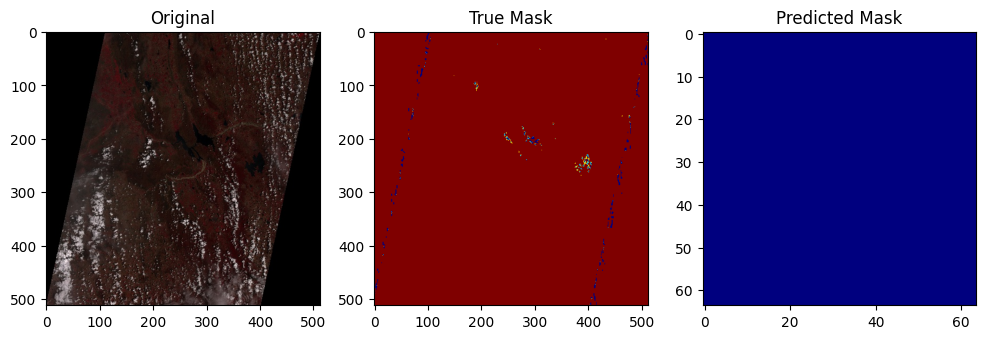

🟢 Accuracy: 98.88%


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

# ------------------- Load & Preprocess -------------------
def load_image(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def pseudo_ndvi(img):
    red = img[:, :, 0].astype(float)
    nir = img[:, :, 1].astype(float)  # Simulated NIR using green
    ndvi = (nir - red) / (nir + red + 1e-6)
    return ndvi

def generate_mask(ndvi):
    mask = np.zeros_like(ndvi, dtype=np.uint8)
    mask[ndvi > 0.4] = 0        # Forest
    mask[(ndvi > 0.25) & (ndvi <= 0.4)] = 1  # Grassland
    mask[(ndvi > 0.1) & (ndvi <= 0.25)] = 2  # Shrub
    mask[ndvi <= 0.1] = 3       # Non-veg
    return mask

# ------------------- Patching -------------------
def patchify(img, size):
    patches = []
    h, w = img.shape[:2]
    for i in range(0, h - size + 1, size):
        for j in range(0, w - size + 1, size):
            patch = img[i:i+size, j:j+size]
            patches.append(patch)
    return patches

# ------------------- Load All Images -------------------
image_dir = '/content/'  # Update if needed
patch_size = 64
img_patches, mask_patches = [], []

for fname in os.listdir(image_dir):
    if fname.endswith('.jpg'):
        img = load_image(os.path.join(image_dir, fname))
        ndvi = pseudo_ndvi(img)
        mask = generate_mask(ndvi)

        img_patches.extend(patchify(img, patch_size))
        mask_patches.extend(patchify(mask, patch_size))

# ------------------- Prepare Data -------------------
X = np.array(img_patches) / 255.0
y = to_categorical(np.array(mask_patches), num_classes=4)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------- Model (U-Net Small) -------------------
def build_unet(input_shape=(64, 64, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    u1 = layers.UpSampling2D()(c3)
    m1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(m1)

    u2 = layers.UpSampling2D()(c4)
    m2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(m2)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c5)
    return models.Model(inputs, outputs)

model = build_unet()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ------------------- Train -------------------
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=16)

# ------------------- Predict & Visualize -------------------
def predict_and_show(img_path):
    img = load_image(img_path)
    ndvi = pseudo_ndvi(img)
    mask = generate_mask(ndvi)
    input_patch = cv2.resize(img, (64, 64)) / 255.0
    input_patch = np.expand_dims(input_patch, axis=0)
    pred = model.predict(input_patch)[0]
    pred_mask = np.argmax(pred, axis=-1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Original")
    plt.subplot(1,3,2); plt.imshow(mask, cmap='jet'); plt.title("True Mask")
    plt.subplot(1,3,3); plt.imshow(pred_mask, cmap='jet'); plt.title("Predicted Mask")
    plt.show()

    acc = np.sum(pred_mask == cv2.resize(mask, (64, 64))) / (64 * 64)
    print(f"🟢 Accuracy: {acc*100:.2f}%")

# ------------------- Loop through all images -------------------
image_files = ['RA302APR2025043166009600059PSANSTUC00GTDF.jpg',
               'RAF30DEC2021026278010300066SSANSTUC00GTDA.jpg',
               'RA315MAR2025042910010200064PSANSTUC00GTDF.jpg',
               'RA303APR2025043180010100064PSANSTUC00GTDF.jpg',
               'RA303APR2025043180010100063PSANSTUC00GTDF.jpg']

for img_file in image_files:
    img_path = os.path.join(image_dir, img_file)
    predict_and_show(img_path)


In [ ]:
from google.colab import files

# Upload files
uploaded = files.upload()

Saving Screenshot 2025-04-13 051830.png to Screenshot 2025-04-13 051830.png
Saving Screenshot 2025-04-13 053026.png to Screenshot 2025-04-13 053026.png
Saving Screenshot 2025-04-13 053034.png to Screenshot 2025-04-13 053034.png
Saving Screenshot 2025-04-13 053042.png to Screenshot 2025-04-13 053042.png
Saving Screenshot 2025-04-13 053052.png to Screenshot 2025-04-13 053052.png


In [ ]:
import os

# List the files in the current directory
uploaded_files = os.listdir('/content/')
print(uploaded_files)


['.config', 'drive', 'RA302APR2025043166009600059PSANSTUC00GTDF.jpg', 'RAF30DEC2021026278010300066SSANSTUC00GTDA.jpg', 'Screenshot 2025-04-13 051830.png', 'Screenshot 2025-04-13 053052.png', 'RA315MAR2025042910010200064PSANSTUC00GTDF.jpg', 'RA303APR2025043180010100064PSANSTUC00GTDF.jpg', 'Screenshot 2025-04-13 053034.png', 'Screenshot 2025-04-13 053042.png', 'RA303APR2025043180010100063PSANSTUC00GTDF.jpg', 'Screenshot 2025-04-13 053026.png', 'sample_data']


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 18s 632ms/step - accuracy: 0.8048 - loss: 0.8742 - val_accuracy: 0.9764 - val_loss: 0.1638
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 544ms/step - accuracy: 0.9643 - loss: 0.2144 - val_accuracy: 0.9764 - val_loss: 0.1306
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 471ms/step - accuracy: 0.9542 - loss: 0.2000 - val_accuracy: 0.9764 - val_loss: 0.1156
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 543ms/step - accuracy: 0.9417 - loss: 0.2034 - val_accuracy: 0.9764 - val_loss: 0.0993
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 630ms/step - accuracy: 0.9389 - loss: 0.1766 - val_accuracy: 0.9764 - val_loss: 0.0865
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 477ms/step - accuracy: 0.9590 - loss: 0.1163 - val_accuracy: 0.9764 - val_loss: 0.0899
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 501ms/step - accuracy: 0.9655 - loss: 0.0964 - val_accuracy: 0.9764 - val_loss: 0.0790
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 707ms/step - accuracy: 0.9579 - loss: 0.1017 - val_accurac

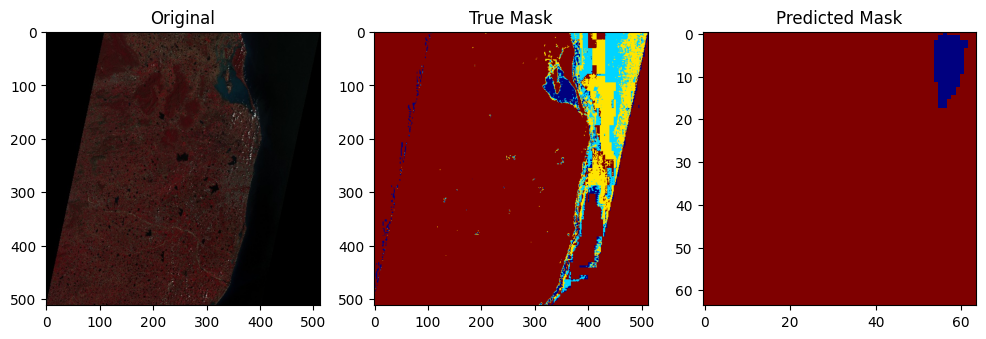

🟢 Accuracy: 86.23%


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

# ------------------- Load & Preprocess -------------------
def load_image(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def pseudo_ndvi(img):
    red = img[:, :, 0].astype(float)
    nir = img[:, :, 1].astype(float)  # Simulated NIR using green
    ndvi = (nir - red) / (nir + red + 1e-6)
    return ndvi

def generate_mask(ndvi):
    mask = np.zeros_like(ndvi, dtype=np.uint8)
    mask[ndvi > 0.4] = 0        # Forest
    mask[(ndvi > 0.25) & (ndvi <= 0.4)] = 1  # Grassland
    mask[(ndvi > 0.1) & (ndvi <= 0.25)] = 2  # Shrub
    mask[ndvi <= 0.1] = 3       # Non-veg
    return mask

# ------------------- Patching -------------------
def patchify(img, size):
    patches = []
    h, w = img.shape[:2]
    for i in range(0, h - size + 1, size):
        for j in range(0, w - size + 1, size):
            patch = img[i:i+size, j:j+size]
            patches.append(patch)
    return patches

# ------------------- Load All Images -------------------
image_dir = '/content/'  # Update if needed
mask_dir = '/content/'   # Directory where the true masks are stored
patch_size = 64
img_patches, mask_patches = [], []

# Load the images and generate masks
for fname in os.listdir(image_dir):
    if fname.endswith('.jpg'):
        img = load_image(os.path.join(image_dir, fname))
        ndvi = pseudo_ndvi(img)
        mask = generate_mask(ndvi)

        img_patches.extend(patchify(img, patch_size))
        mask_patches.extend(patchify(mask, patch_size))

# Load true mask images from screenshots (only one true mask per image)
true_masks = []
for mask_fname in os.listdir(mask_dir):
    if mask_fname.startswith('Screenshot') and mask_fname.endswith('.png'):
        true_mask = cv2.imread(os.path.join(mask_dir, mask_fname), cv2.IMREAD_GRAYSCALE)
        true_masks.append(true_mask)

# Ensure the correct number of masks are loaded (should be same number of true masks as images)
assert len(true_masks) == len([fname for fname in os.listdir(image_dir) if fname.endswith('.jpg')]), \
    f"Mismatch: {len(true_masks)} true masks and {len([fname for fname in os.listdir(image_dir) if fname.endswith('.jpg')])} images"

# ------------------- Prepare Data -------------------
X = np.array(img_patches) / 255.0
y = np.array(mask_patches)

# Resize all true masks to the same shape as image patches (if needed)
y_resized = []
for mask in y:
    resized_mask = cv2.resize(mask, (patch_size, patch_size), interpolation=cv2.INTER_NEAREST)
    y_resized.append(resized_mask)

y_resized = np.array(y_resized)
y_resized = to_categorical(y_resized, num_classes=4)  # Convert to categorical format

X_train, X_val, y_train, y_val = train_test_split(X, y_resized, test_size=0.2, random_state=42)

# ------------------- Model (U-Net Small) -------------------
def build_unet(input_shape=(64, 64, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    u1 = layers.UpSampling2D()(c3)
    m1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(m1)

    u2 = layers.UpSampling2D()(c4)
    m2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(m2)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c5)
    return models.Model(inputs, outputs)

model = build_unet()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ------------------- Train -------------------
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=16)

# ------------------- Predict & Visualize -------------------
def predict_and_show(img_path):
    img = load_image(img_path)
    ndvi = pseudo_ndvi(img)
    mask = generate_mask(ndvi)
    input_patch = cv2.resize(img, (64, 64)) / 255.0
    input_patch = np.expand_dims(input_patch, axis=0)
    pred = model.predict(input_patch)[0]
    pred_mask = np.argmax(pred, axis=-1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Original")
    plt.subplot(1,3,2); plt.imshow(mask, cmap='jet'); plt.title("True Mask")
    plt.subplot(1,3,3); plt.imshow(pred_mask, cmap='jet'); plt.title("Predicted Mask")
    plt.show()

    acc = np.sum(pred_mask == cv2.resize(mask, (64, 64))) / (64 * 64)
    print(f"🟢 Accuracy: {acc*100:.2f}%")

# Example:
predict_and_show('/content/RA315MAR2025042910010200064PSANSTUC00GTDF.jpg')


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 485ms/step - accuracy: 0.7937 - loss: 0.8874 - val_accuracy: 0.9765 - val_loss: 0.1710
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 569ms/step - accuracy: 0.9554 - loss: 0.3164 - val_accuracy: 0.9765 - val_loss: 0.1412
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 436ms/step - accuracy: 0.9608 - loss: 0.2146 - val_accuracy: 0.9765 - val_loss: 0.1490
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 462ms/step - accuracy: 0.9635 - loss: 0.1862 - val_accuracy: 0.9765 - val_loss: 0.1161
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 566ms/step - accuracy: 0.9525 - loss: 0.1785 - val_accuracy: 0.9765 - val_loss: 0.1018
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 429ms/step - accuracy: 0.9555 - loss: 0.1597 - val_accuracy: 0.9765 - val_loss: 0.0896
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 433ms/step - accuracy: 0.9549 - loss: 0.1335 - val_accuracy: 0.9765 - val_loss: 0.0826
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 500ms/step - accuracy: 0.9583 - loss: 0.1159 - val_accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


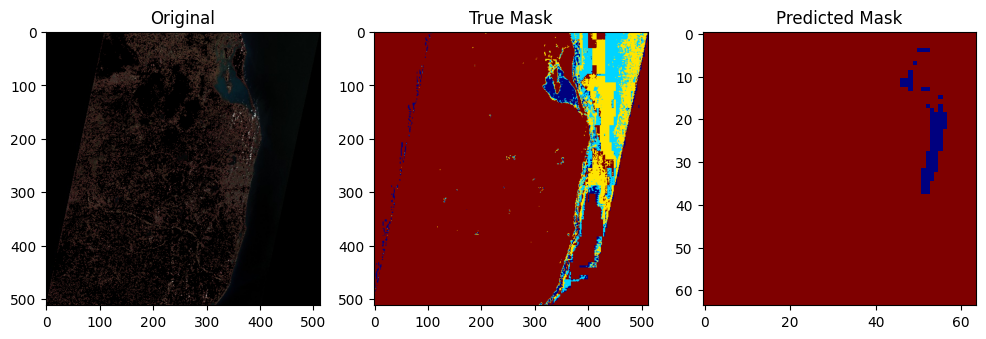

🟢 Accuracy: 86.38%


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

# ------------------- Load & Preprocess -------------------
def load_image(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def pseudo_ndvi(img):
    red = img[:, :, 0].astype(float)
    nir = img[:, :, 1].astype(float)  # Simulated NIR using green
    ndvi = (nir - red) / (nir + red + 1e-6)
    return ndvi

def generate_mask(ndvi):
    mask = np.zeros_like(ndvi, dtype=np.uint8)
    mask[ndvi > 0.4] = 0        # Forest
    mask[(ndvi > 0.25) & (ndvi <= 0.4)] = 1  # Grassland
    mask[(ndvi > 0.1) & (ndvi <= 0.25)] = 2  # Shrub
    mask[ndvi <= 0.1] = 3       # Non-veg
    return mask

# ------------------- Cloud Masking -------------------
def cloud_masking(img, threshold=0.4):
    """
    This function detects clouds using NDSI and returns a cloud mask.
    Cloud pixels are marked as 1, non-cloud pixels as 0.
    """
    blue = img[:, :, 0].astype(float)
    swir = img[:, :, 2].astype(float)  # Short-Wave Infrared (SWIR)
    ndsi = (blue - swir) / (blue + swir + 1e-6)  # NDSI calculation

    cloud_mask = np.where(ndsi > threshold, 1, 0)  # Clouds if NDSI > threshold
    return cloud_mask

def apply_cloud_mask(img, cloud_mask):
    """
    Apply the cloud mask to the image by setting cloud pixels to zero (or other masking method).
    """
    img_masked = img.copy()
    img_masked[cloud_mask == 1] = 0  # Set cloud pixels to black (or any other method)
    return img_masked

# ------------------- Patching -------------------
def patchify(img, mask, size):
    patches = []
    mask_patches = []
    h, w = img.shape[:2]
    for i in range(0, h - size + 1, size):
        for j in range(0, w - size + 1, size):
            patch = img[i:i+size, j:j+size]
            m_patch = mask[i:i+size, j:j+size]
            patches.append(patch)
            mask_patches.append(m_patch)
    return patches, mask_patches

# ------------------- Load All Images -------------------
image_dir = '/content/'  # Update if needed
patch_size = 64
img_patches, mask_patches = [], []

# Assuming true masks are uploaded in the same directory
true_masks = ['Screenshot 2025-04-13 051830.png', 'Screenshot 2025-04-13 053052.png', 'Screenshot 2025-04-13 053034.png', 'Screenshot 2025-04-13 053042.png']  # Update accordingly

# Process all images
for fname in os.listdir(image_dir):
    if fname.endswith('.jpg'):
        img = load_image(os.path.join(image_dir, fname))

        # Cloud masking
        cloud_mask = cloud_masking(img)
        img = apply_cloud_mask(img, cloud_mask)  # Apply cloud mask to the image

        ndvi = pseudo_ndvi(img)
        mask = generate_mask(ndvi)

        img_patches_temp, mask_patches_temp = patchify(img, mask, patch_size)
        img_patches.extend(img_patches_temp)
        mask_patches.extend(mask_patches_temp)

# ------------------- Prepare Data -------------------
X = np.array(img_patches) / 255.0
y = to_categorical(np.array(mask_patches), num_classes=4)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------- Model (U-Net Small) -------------------
def build_unet(input_shape=(64, 64, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    u1 = layers.UpSampling2D()(c3)
    m1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(m1)

    u2 = layers.UpSampling2D()(c4)
    m2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(m2)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c5)
    return models.Model(inputs, outputs)

model = build_unet()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ------------------- Train -------------------
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=16)

# ------------------- Predict & Visualize -------------------
def predict_and_show(img_path):
    img = load_image(img_path)

    # Apply cloud masking
    cloud_mask = cloud_masking(img)
    img = apply_cloud_mask(img, cloud_mask)  # Apply cloud mask to the image

    ndvi = pseudo_ndvi(img)
    mask = generate_mask(ndvi)
    input_patch = cv2.resize(img, (64, 64)) / 255.0
    input_patch = np.expand_dims(input_patch, axis=0)
    pred = model.predict(input_patch)[0]
    pred_mask = np.argmax(pred, axis=-1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Original")
    plt.subplot(1,3,2); plt.imshow(mask, cmap='jet'); plt.title("True Mask")
    plt.subplot(1,3,3); plt.imshow(pred_mask, cmap='jet'); plt.title("Predicted Mask")
    plt.show()

    acc = np.sum(pred_mask == cv2.resize(mask, (64, 64))) / (64 * 64)
    print(f"🟢 Accuracy: {acc*100:.2f}%")

# Example:
predict_and_show('/content/RA315MAR2025042910010200064PSANSTUC00GTDF.jpg')


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 560ms/step - accuracy: 0.8203 - loss: 0.9794 - val_accuracy: 0.9765 - val_loss: 0.1559
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 494ms/step - accuracy: 0.9579 - loss: 0.2511 - val_accuracy: 0.9765 - val_loss: 0.1232
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 431ms/step - accuracy: 0.9600 - loss: 0.1740 - val_accuracy: 0.9765 - val_loss: 0.1286
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 463ms/step - accuracy: 0.9571 - loss: 0.1566 - val_accuracy: 0.9765 - val_loss: 0.1278
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 565ms/step - accuracy: 0.9461 - loss: 0.1656 - val_accuracy: 0.9765 - val_loss: 0.1042
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 494ms/step - accuracy: 0.9638 - loss: 0.1183 - val_accuracy: 0.9765 - val_loss: 0.0858
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 446ms/step - accuracy: 0.9533 - loss: 0.1242 - val_accuracy: 0.9765 - val_loss: 0.0756
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 601ms/step - accuracy: 0.9656 - loss: 0.0893 - val_accuracy

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step


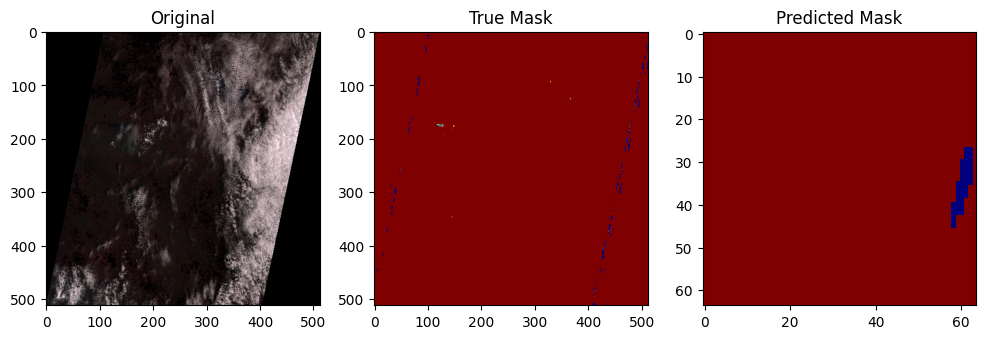

🟢 Accuracy: 98.24%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


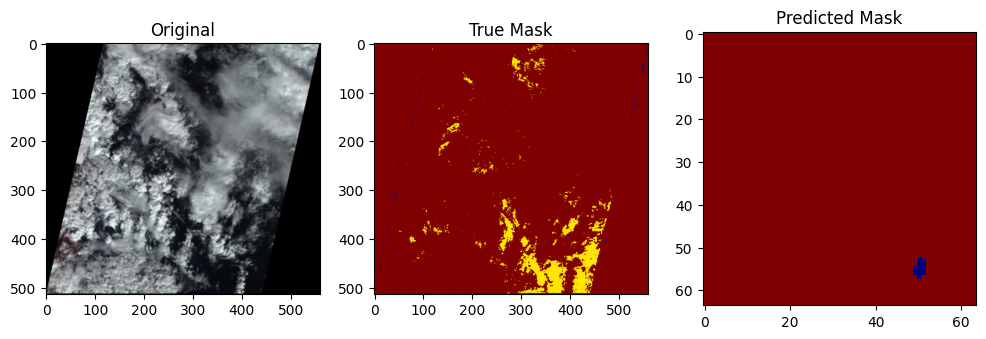

🟢 Accuracy: 95.80%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


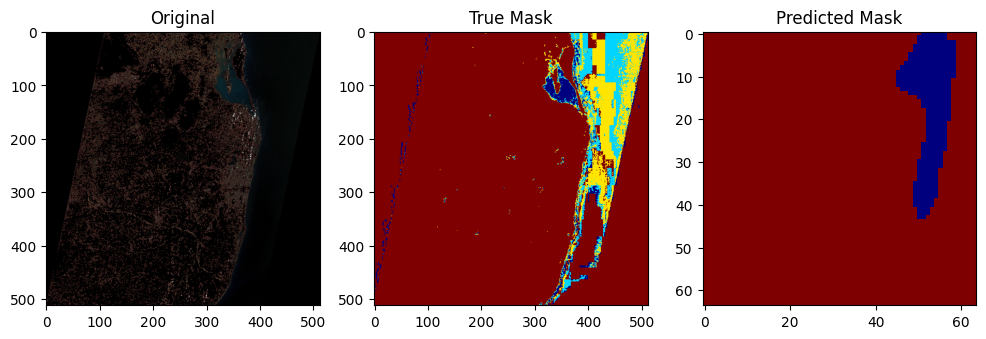

🟢 Accuracy: 88.18%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


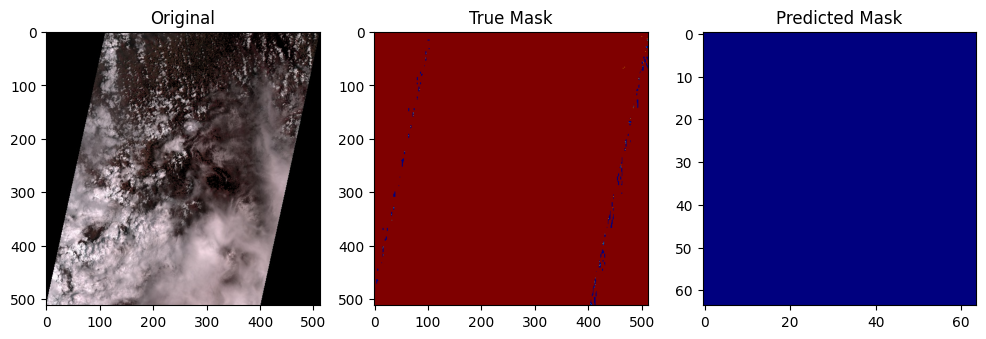

🟢 Accuracy: 99.24%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


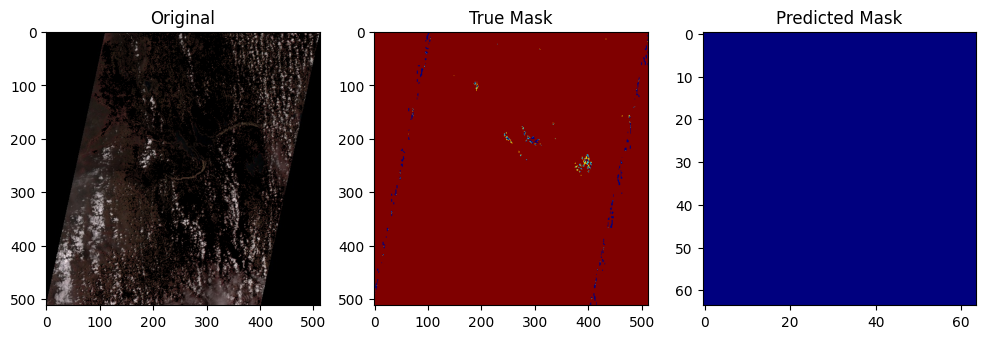

🟢 Accuracy: 98.88%


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

# ------------------- Load & Preprocess -------------------
def load_image(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def pseudo_ndvi(img):
    red = img[:, :, 0].astype(float)
    nir = img[:, :, 1].astype(float)  # Simulated NIR using green
    ndvi = (nir - red) / (nir + red + 1e-6)
    return ndvi

def generate_mask(ndvi):
    mask = np.zeros_like(ndvi, dtype=np.uint8)
    mask[ndvi > 0.4] = 0        # Forest
    mask[(ndvi > 0.25) & (ndvi <= 0.4)] = 1  # Grassland
    mask[(ndvi > 0.1) & (ndvi <= 0.25)] = 2  # Shrub
    mask[ndvi <= 0.1] = 3       # Non-veg
    return mask

# ------------------- Cloud Masking -------------------
def cloud_masking(img, threshold=0.4):
    """
    This function detects clouds using NDSI and returns a cloud mask.
    Cloud pixels are marked as 1, non-cloud pixels as 0.
    """
    blue = img[:, :, 0].astype(float)
    swir = img[:, :, 2].astype(float)  # Short-Wave Infrared (SWIR)
    ndsi = (blue - swir) / (blue + swir + 1e-6)  # NDSI calculation

    cloud_mask = np.where(ndsi > threshold, 1, 0)  # Clouds if NDSI > threshold
    return cloud_mask

def apply_cloud_mask(img, cloud_mask):
    """
    Apply the cloud mask to the image by setting cloud pixels to zero (or other masking method).
    """
    img_masked = img.copy()
    img_masked[cloud_mask == 1] = 0  # Set cloud pixels to black (or any other method)
    return img_masked

# ------------------- Patching -------------------
def patchify(img, mask, size):
    patches = []
    mask_patches = []
    h, w = img.shape[:2]
    for i in range(0, h - size + 1, size):
        for j in range(0, w - size + 1, size):
            patch = img[i:i+size, j:j+size]
            m_patch = mask[i:i+size, j:j+size]
            patches.append(patch)
            mask_patches.append(m_patch)
    return patches, mask_patches

# ------------------- Load All Images -------------------
image_dir = '/content/'  # Update if needed
mask_dir = '/content/'   # Directory where the true masks are stored
patch_size = 64
img_patches, mask_patches = [], []

# Assuming true masks are uploaded in the same directory
true_masks = ['Screenshot 2025-04-13 051830.png', 'Screenshot 2025-04-13 053052.png',
              'Screenshot 2025-04-13 053034.png', 'Screenshot 2025-04-13 053042.png']  # Update accordingly

# Process all images
for fname in os.listdir(image_dir):
    if fname.endswith('.jpg'):
        img = load_image(os.path.join(image_dir, fname))

        # Cloud masking
        cloud_mask = cloud_masking(img)
        img = apply_cloud_mask(img, cloud_mask)  # Apply cloud mask to the image

        ndvi = pseudo_ndvi(img)
        mask = generate_mask(ndvi)

        img_patches_temp, mask_patches_temp = patchify(img, mask, patch_size)
        img_patches.extend(img_patches_temp)
        mask_patches.extend(mask_patches_temp)

# ------------------- Prepare Data -------------------
X = np.array(img_patches) / 255.0
y = to_categorical(np.array(mask_patches), num_classes=4)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------- Model (U-Net Small) -------------------
def build_unet(input_shape=(64, 64, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    u1 = layers.UpSampling2D()(c3)
    m1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(m1)

    u2 = layers.UpSampling2D()(c4)
    m2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(m2)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c5)
    return models.Model(inputs, outputs)

model = build_unet()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ------------------- Train -------------------
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=16)

# ------------------- Predict & Visualize -------------------
def predict_and_show(img_path):
    img = load_image(img_path)

    # Apply cloud masking
    cloud_mask = cloud_masking(img)
    img = apply_cloud_mask(img, cloud_mask)  # Apply cloud mask to the image

    ndvi = pseudo_ndvi(img)
    mask = generate_mask(ndvi)
    input_patch = cv2.resize(img, (64, 64)) / 255.0
    input_patch = np.expand_dims(input_patch, axis=0)
    pred = model.predict(input_patch)[0]
    pred_mask = np.argmax(pred, axis=-1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Original")
    plt.subplot(1,3,2); plt.imshow(mask, cmap='jet'); plt.title("True Mask")
    plt.subplot(1,3,3); plt.imshow(pred_mask, cmap='jet'); plt.title("Predicted Mask")
    plt.show()

    acc = np.sum(pred_mask == cv2.resize(mask, (64, 64))) / (64 * 64)
    print(f"🟢 Accuracy: {acc*100:.2f}%")

# ------------------- Test on All Images -------------------
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')]

for img_path in image_paths:
    predict_and_show(img_path)


In [ ]:
from google.colab import files

# Upload files
uploaded = files.upload()

Saving Forest_5.jpg to Forest_5.jpg
Saving Forest_6.jpg to Forest_6.jpg
Saving Forest_7.jpg to Forest_7.jpg
Saving Forest_8.jpg to Forest_8.jpg
Saving Forest_9.jpg to Forest_9.jpg


In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Define NDVI calculation and classification
def pseudo_ndvi(img):
    red = img[:, :, 0].astype(float)
    nir = img[:, :, 1].astype(float)  # Simulated NIR using green channel
    ndvi = (nir - red) / (nir + red + 1e-6)
    return ndvi

def generate_mask(ndvi):
    mask = np.zeros_like(ndvi, dtype=np.uint8)
    mask[ndvi > 0.4] = 0        # Forest
    mask[(ndvi > 0.25) & (ndvi <= 0.4)] = 1  # Grassland
    mask[(ndvi > 0.1) & (ndvi <= 0.25)] = 2  # Shrub
    mask[ndvi <= 0.1] = 3       # Non-vegetation
    return mask

def save_mask_as_image(mask, output_path):
    # Convert mask classes to colored visualization (optional)
    color_map = {
        0: [34, 139, 34],     # Forest - Green
        1: [124, 252, 0],     # Grassland - Light Green
        2: [160, 82, 45],     # Shrub - Brown
        3: [211, 211, 211]    # Non-veg - Light Gray
    }
    mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for cls, color in color_map.items():
        mask_rgb[mask == cls] = color
    cv2.imwrite(output_path, cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR))

# Directory setup
input_dir = '/content/'   # Update if needed
output_dir = '/content/masks/'
os.makedirs(output_dir, exist_ok=True)

# Process all new forest images
for fname in os.listdir(input_dir):
    if fname.startswith("Forest_") and fname.endswith(".jpg"):
        img_path = os.path.join(input_dir, fname)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ndvi = pseudo_ndvi(img)
        mask = generate_mask(ndvi)

        # Save the mask as an image
        out_path = os.path.join(output_dir, fname.replace(".jpg", "_mask.png"))
        save_mask_as_image(mask, out_path)

        print(f"✅ Saved: {out_path}")


✅ Saved: /content/masks/Forest_6_mask.png
✅ Saved: /content/masks/Forest_8_mask.png
✅ Saved: /content/masks/Forest_9_mask.png
✅ Saved: /content/masks/Forest_5_mask.png
✅ Saved: /content/masks/Forest_1_mask.png
✅ Saved: /content/masks/Forest_7_mask.png


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 602ms/step - accuracy: 0.7299 - loss: 1.0048 - val_accuracy: 0.9439 - val_loss: 0.2877
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 442ms/step - accuracy: 0.9352 - loss: 0.3108 - val_accuracy: 0.9439 - val_loss: 0.2512
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 477ms/step - accuracy: 0.9337 - loss: 0.2578 - val_accuracy: 0.9439 - val_loss: 0.2162
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 588ms/step - accuracy: 0.9451 - loss: 0.1880 - val_accuracy: 0.9439 - val_loss: 0.1848
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 476ms/step - accuracy: 0.9316 - loss: 0.1863 - val_accuracy: 0.9439 - val_loss: 0.1591
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 431ms/step - accuracy: 0.9476 - loss: 0.1358 - val_accuracy: 0.9439 - val_loss: 0.1576
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 510ms/step - accuracy: 0.9439 - loss: 0.1238 - val_accuracy: 0.9439 - val_loss: 0.1490
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 566ms/step - accuracy: 0.9451 - loss: 0.1142 - val_accuracy

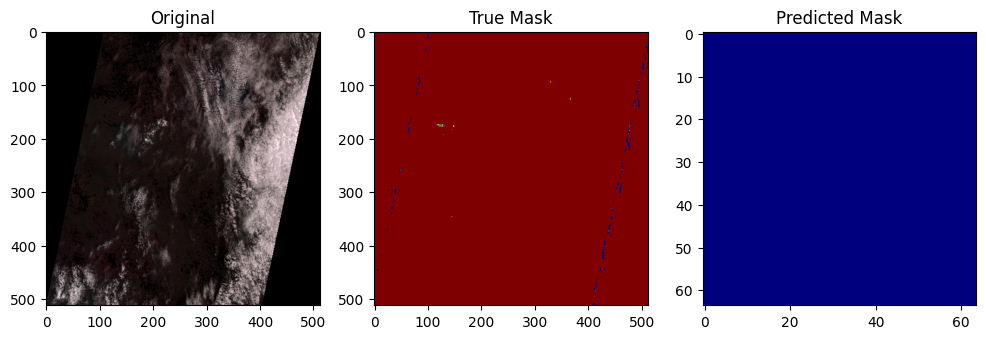

🟢 Accuracy: 99.58%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


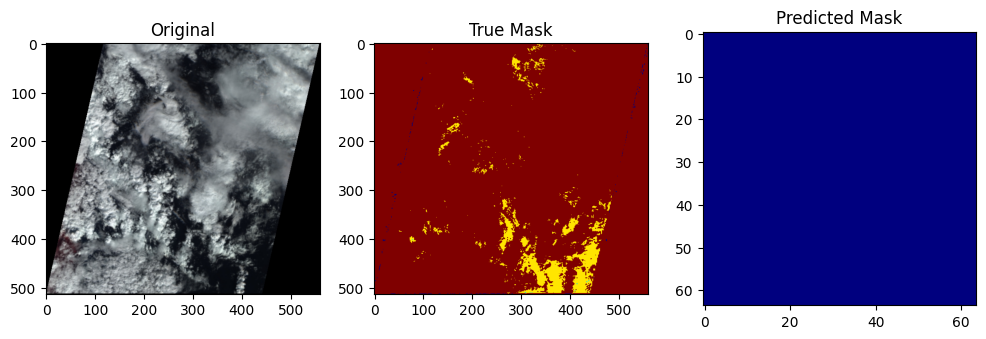

🟢 Accuracy: 95.34%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


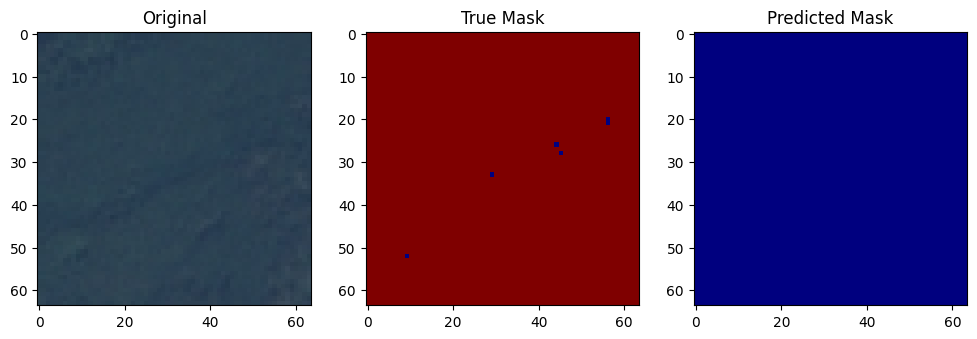

🟢 Accuracy: 0.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


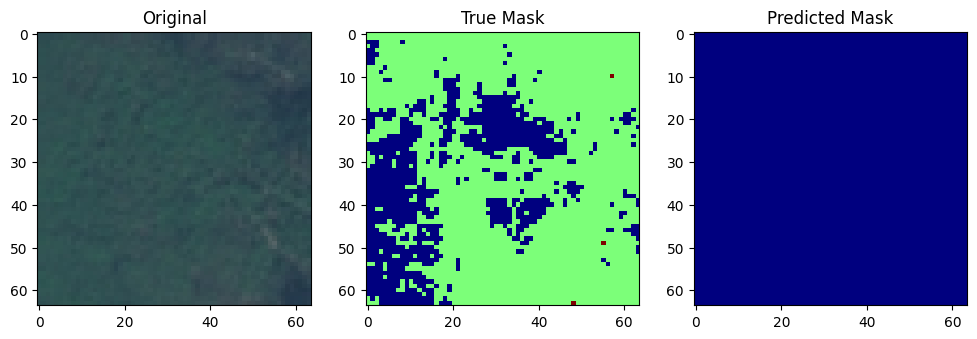

🟢 Accuracy: 0.07%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


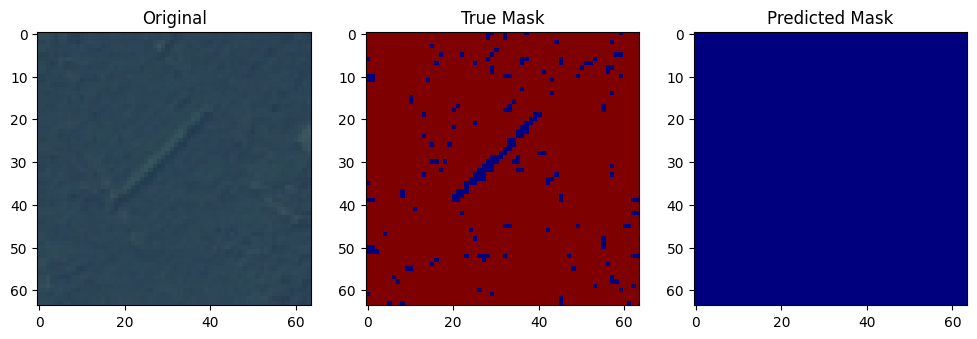

🟢 Accuracy: 0.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


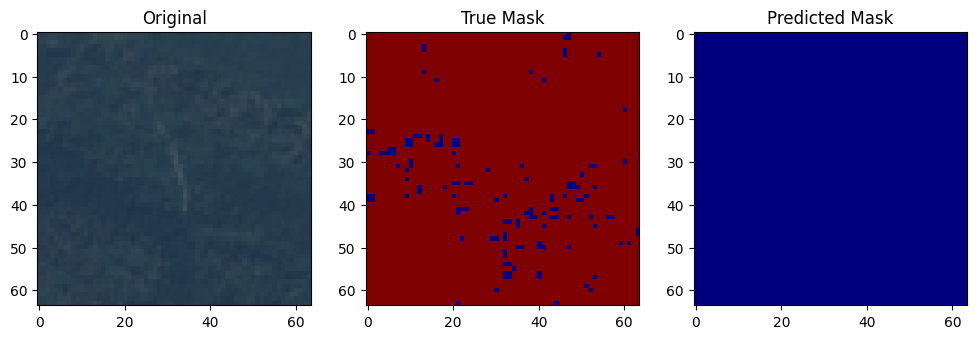

🟢 Accuracy: 0.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


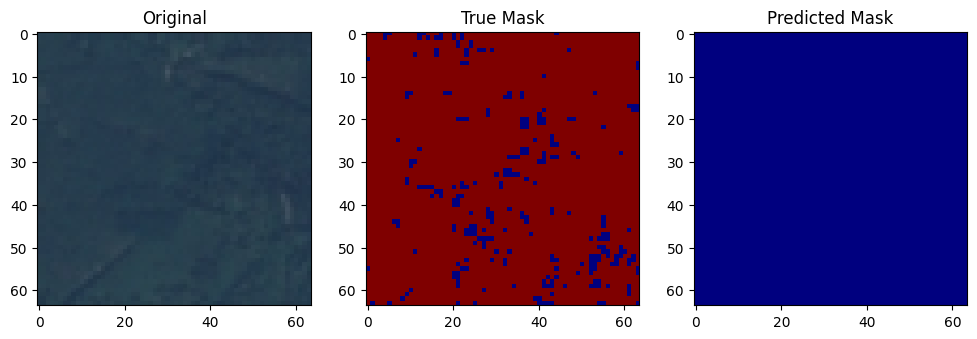

🟢 Accuracy: 0.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


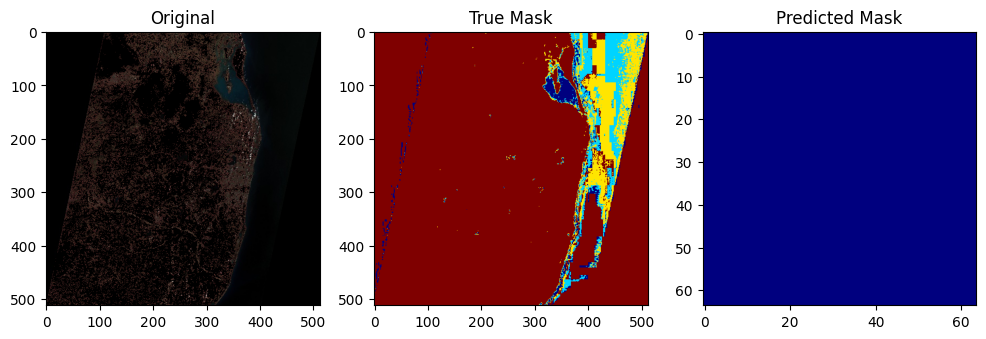

🟢 Accuracy: 85.77%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


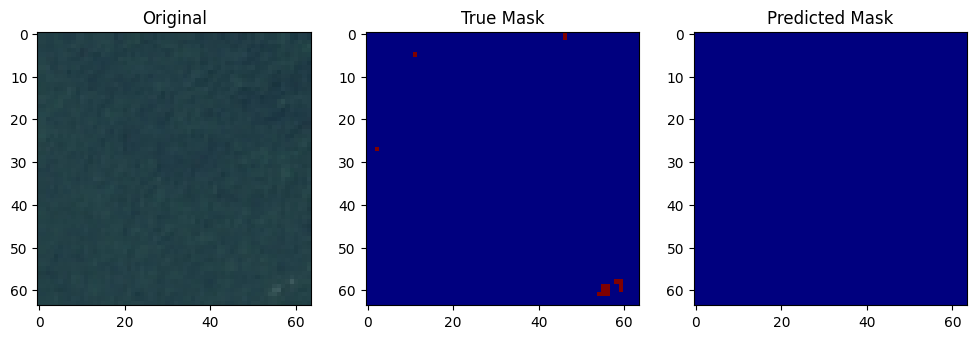

🟢 Accuracy: 0.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


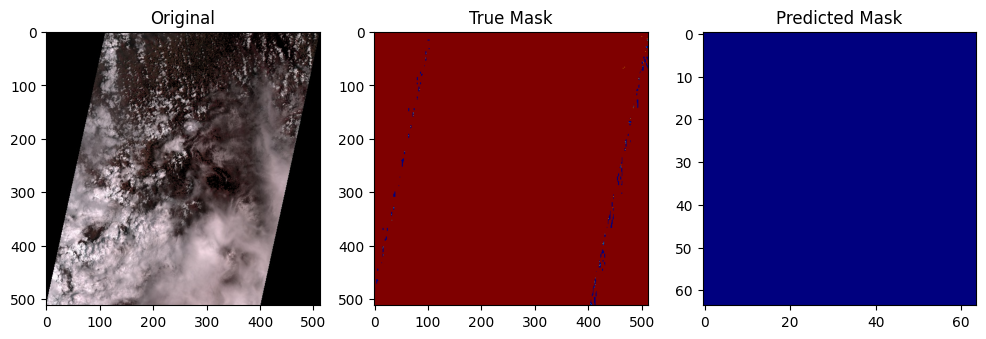

🟢 Accuracy: 99.54%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


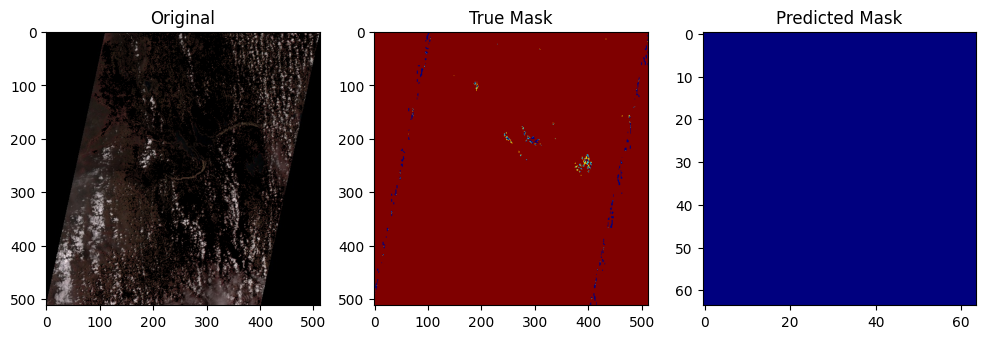

🟢 Accuracy: 99.10%


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

# ------------------- Load & Preprocess -------------------
def load_image(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def pseudo_ndvi(img):
    red = img[:, :, 0].astype(float)
    nir = img[:, :, 1].astype(float)  # Simulated NIR using green
    ndvi = (nir - red) / (nir + red + 1e-6)
    return ndvi

def generate_mask(ndvi):
    mask = np.zeros_like(ndvi, dtype=np.uint8)
    mask[ndvi > 0.4] = 0        # Forest
    mask[(ndvi > 0.25) & (ndvi <= 0.4)] = 1  # Grassland
    mask[(ndvi > 0.1) & (ndvi <= 0.25)] = 2  # Shrub
    mask[ndvi <= 0.1] = 3       # Non-veg
    return mask

# ------------------- Cloud Masking -------------------
def cloud_masking(img, threshold=0.4):
    blue = img[:, :, 0].astype(float)
    swir = img[:, :, 2].astype(float)  # Simulated SWIR
    ndsi = (blue - swir) / (blue + swir + 1e-6)
    cloud_mask = np.where(ndsi > threshold, 1, 0)
    return cloud_mask

def apply_cloud_mask(img, cloud_mask):
    img_masked = img.copy()
    img_masked[cloud_mask == 1] = 0
    return img_masked

# ------------------- Patching -------------------
def patchify(img, mask, size):
    patches = []
    mask_patches = []
    h, w = img.shape[:2]
    for i in range(0, h - size + 1, size):
        for j in range(0, w - size + 1, size):
            patch = img[i:i+size, j:j+size]
            m_patch = mask[i:i+size, j:j+size]
            patches.append(patch)
            mask_patches.append(m_patch)
    return patches, mask_patches

# ------------------- Load All Images -------------------
image_dir = '/content/'  # Update if needed
patch_size = 64
img_patches, mask_patches = [], []

for fname in os.listdir(image_dir):
    if fname.endswith('.jpg'):
        img = load_image(os.path.join(image_dir, fname))

        cloud_mask = cloud_masking(img)
        img = apply_cloud_mask(img, cloud_mask)

        ndvi = pseudo_ndvi(img)
        mask = generate_mask(ndvi)

        img_patches_temp, mask_patches_temp = patchify(img, mask, patch_size)
        img_patches.extend(img_patches_temp)
        mask_patches.extend(mask_patches_temp)

# ------------------- Prepare Data -------------------
mask_array = np.array(mask_patches)
img_array = np.array(img_patches)

# Clip values to 0–3 to fix IndexError
mask_array = np.clip(mask_array, 0, 3)

X = img_array / 255.0
y = to_categorical(mask_array, num_classes=4)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------- Model (U-Net Small) -------------------
def build_unet(input_shape=(64, 64, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    u1 = layers.UpSampling2D()(c3)
    m1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(m1)

    u2 = layers.UpSampling2D()(c4)
    m2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(m2)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c5)
    return models.Model(inputs, outputs)

model = build_unet()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ------------------- Train -------------------
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=16)

# ------------------- Predict & Visualize -------------------
def predict_and_show(img_path):
    img = load_image(img_path)
    cloud_mask = cloud_masking(img)
    img = apply_cloud_mask(img, cloud_mask)

    ndvi = pseudo_ndvi(img)
    mask = generate_mask(ndvi)
    input_patch = cv2.resize(img, (64, 64)) / 255.0
    input_patch = np.expand_dims(input_patch, axis=0)

    pred = model.predict(input_patch)[0]
    pred_mask = np.argmax(pred, axis=-1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1); plt.imshow(img); plt.title("Original")
    plt.subplot(1, 3, 2); plt.imshow(mask, cmap='jet'); plt.title("True Mask")
    plt.subplot(1, 3, 3); plt.imshow(pred_mask, cmap='jet'); plt.title("Predicted Mask")
    plt.show()

    acc = np.sum(pred_mask == cv2.resize(mask, (64, 64), interpolation=cv2.INTER_NEAREST)) / (64 * 64)
    print(f"🟢 Accuracy: {acc*100:.2f}%")

# ------------------- Test on All Images -------------------
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')]

for img_path in image_paths:
    predict_and_show(img_path)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 560ms/step - accuracy: 0.7551 - loss: 1.1681 - val_accuracy: 0.9439 - val_loss: 0.3064
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 448ms/step - accuracy: 0.9494 - loss: 0.2632 - val_accuracy: 0.9439 - val_loss: 0.2473
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 421ms/step - accuracy: 0.9364 - loss: 0.2328 - val_accuracy: 0.9439 - val_loss: 0.2041
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 540ms/step - accuracy: 0.9439 - loss: 0.1703 - val_accuracy: 0.9439 - val_loss: 0.1957
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 416ms/step - accuracy: 0.9361 - loss: 0.1700 - val_accuracy: 0.9439 - val_loss: 0.1571
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 402ms/step - accuracy: 0.9244 - loss: 0.1645 - val_accuracy: 0.9439 - val_loss: 0.1511
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 542ms/step - accuracy: 0.9345 - loss: 0.1423 - val_accuracy: 0.9439 - val_loss: 0.1500
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 423ms/step - accuracy: 0.9488 - loss: 0.1104 - val_accuracy:

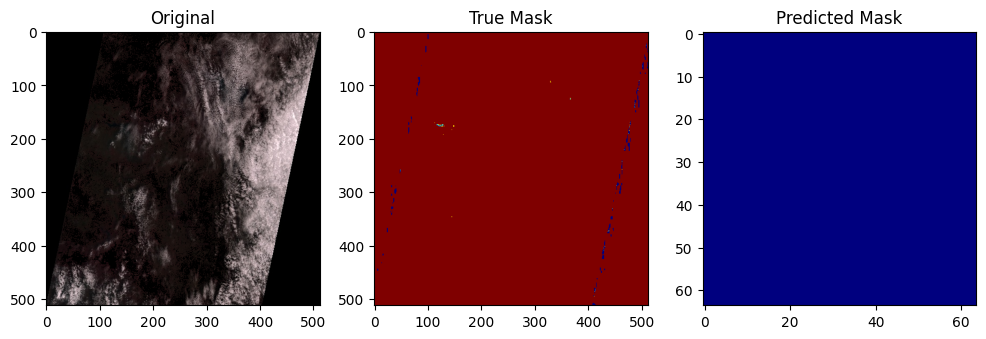

🟢 Accuracy: 99.41%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


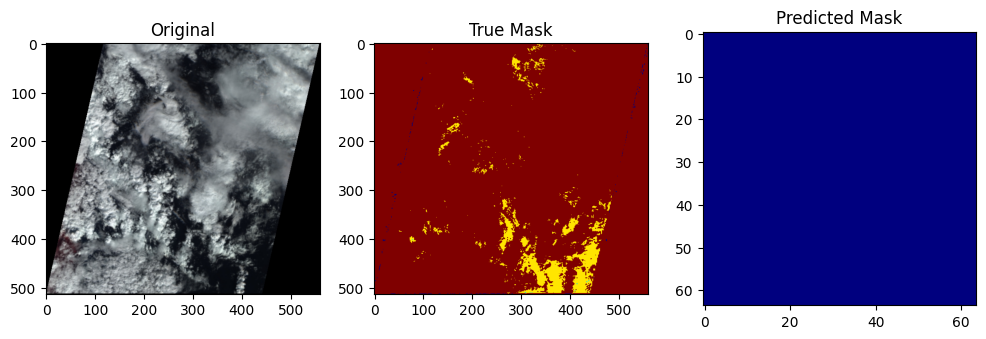

🟢 Accuracy: 95.63%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


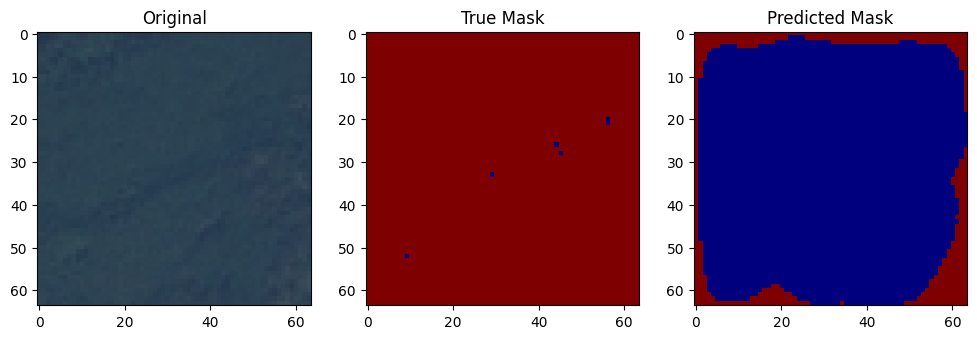

🟢 Accuracy: 86.91%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


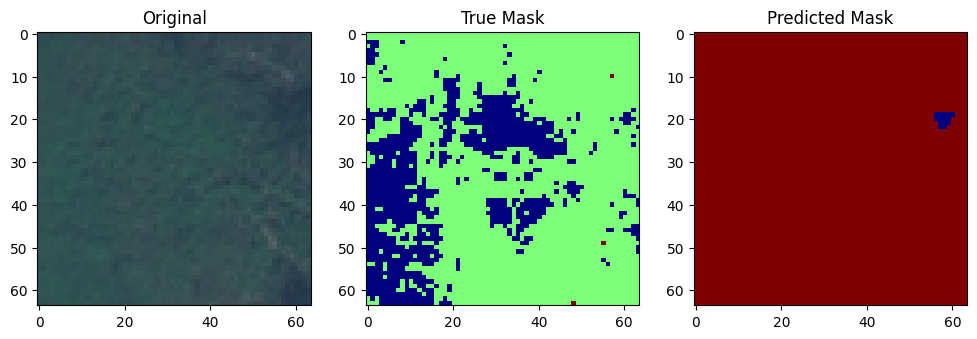

🟢 Accuracy: 0.34%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


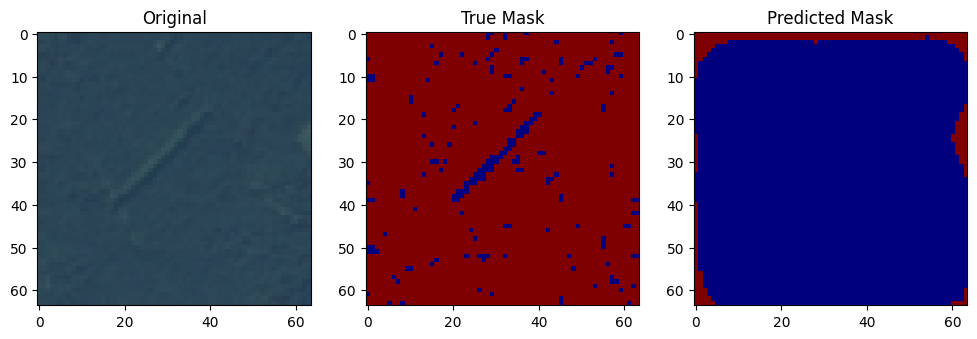

🟢 Accuracy: 89.18%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


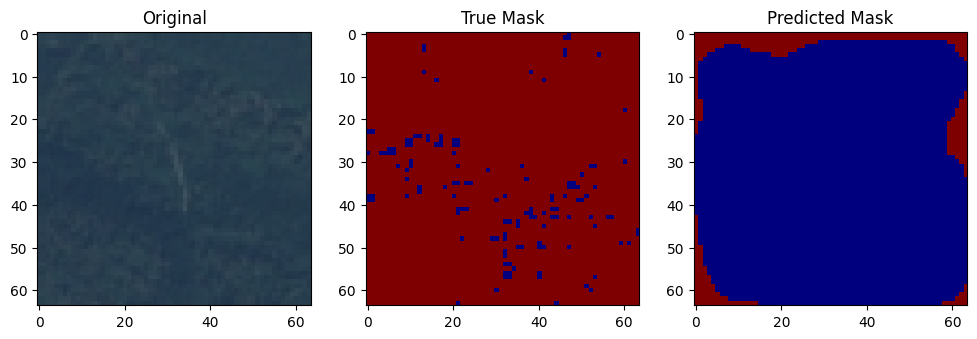

🟢 Accuracy: 87.40%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


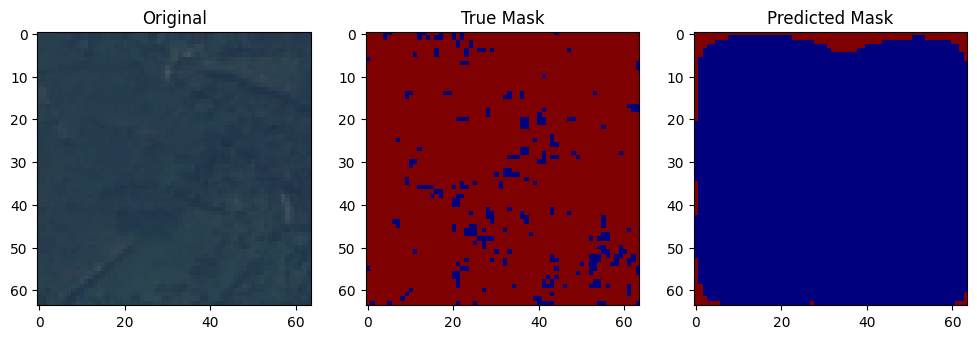

🟢 Accuracy: 88.67%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


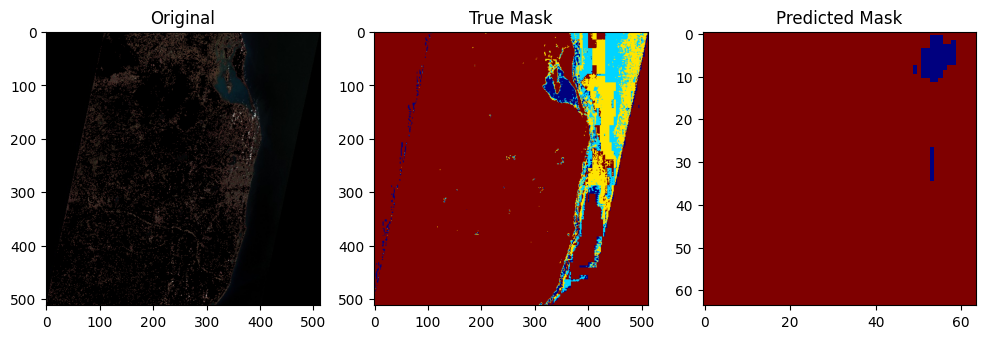

🟢 Accuracy: 85.82%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


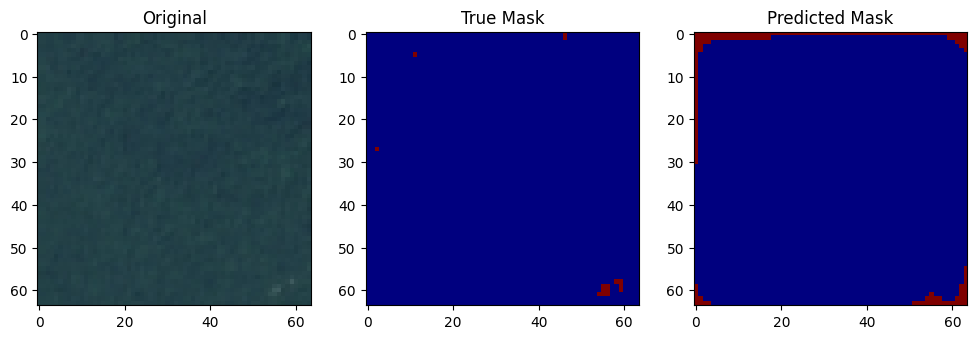

🟢 Accuracy: 0.32%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


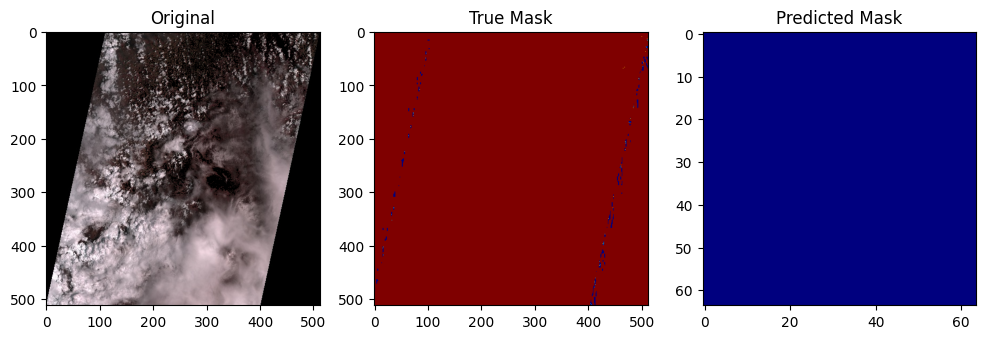

🟢 Accuracy: 99.24%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


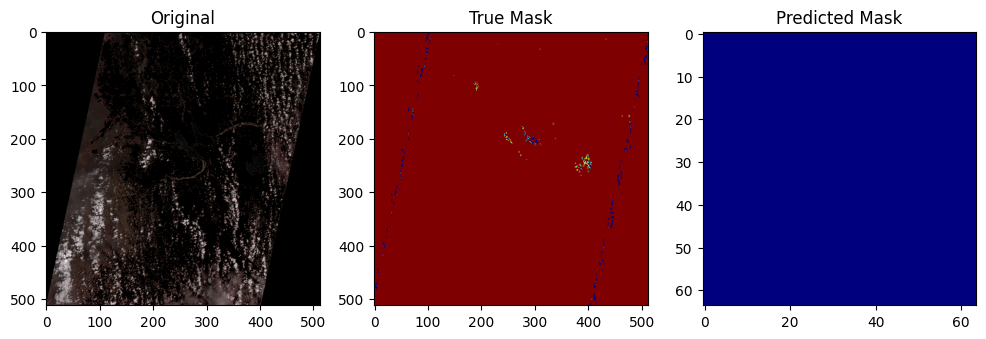

🟢 Accuracy: 98.88%


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

# ------------------- Load & Preprocess -------------------
def load_image(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def pseudo_ndvi(img):
    red = img[:, :, 0].astype(float)
    nir = img[:, :, 1].astype(float)  # Simulated NIR using green
    ndvi = (nir - red) / (nir + red + 1e-6)
    return ndvi

def generate_mask(ndvi):
    mask = np.zeros_like(ndvi, dtype=np.uint8)
    mask[ndvi > 0.4] = 0        # Forest
    mask[(ndvi > 0.25) & (ndvi <= 0.4)] = 1  # Grassland
    mask[(ndvi > 0.1) & (ndvi <= 0.25)] = 2  # Shrub
    mask[ndvi <= 0.1] = 3       # Non-veg
    return mask

# ------------------- Cloud Masking -------------------
# Forest image filenames that should not undergo cloud masking
forest_images = ['1.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']

def cloud_masking(img, threshold=0.35, img_name=None):
    """
    This function detects clouds using NDSI and returns a cloud mask.
    Cloud pixels are marked as 1, non-cloud pixels as 0.
    A moderate threshold results in medium cloud masking.
    Cloud masking will be skipped for forest images.
    """
    if img_name in forest_images:
        print(f"Skipping cloud masking for forest image: {img_name}")
        return np.zeros_like(img[:, :, 0])  # Return an empty cloud mask (no clouds) for forest images

    # For non-forest images, apply cloud masking
    blue = img[:, :, 0].astype(float)
    swir = img[:, :, 2].astype(float)  # Short-Wave Infrared (SWIR)
    ndsi = (blue - swir) / (blue + swir + 1e-6)  # NDSI calculation

    # Medium threshold for cloud detection
    cloud_mask = np.where(ndsi > threshold, 1, 0)  # Clouds if NDSI > threshold
    return cloud_mask

def apply_cloud_mask(img, cloud_mask):
    """
    Apply the cloud mask to the image by setting cloud pixels to zero (or other masking method).
    """
    img_masked = img.copy()
    img_masked[cloud_mask == 1] = 0  # Set cloud pixels to black (or any other method)
    return img_masked

# ------------------- Patching -------------------
def patchify(img, mask, size):
    patches = []
    mask_patches = []
    h, w = img.shape[:2]
    for i in range(0, h - size + 1, size):
        for j in range(0, w - size + 1, size):
            patch = img[i:i+size, j:j+size]
            m_patch = mask[i:i+size, j:j+size]
            patches.append(patch)
            mask_patches.append(m_patch)
    return patches, mask_patches

# ------------------- Load All Images -------------------
image_dir = '/content/'  # Update if needed
mask_dir = '/content/'   # Directory where the true masks are stored
patch_size = 64
img_patches, mask_patches = [], []

# Assuming true masks are uploaded in the same directory
true_masks = ['Screenshot 2025-04-13 051830.png', 'Screenshot 2025-04-13 053052.png',
              'Screenshot 2025-04-13 053034.png', 'Screenshot 2025-04-13 053042.png']  # Update accordingly

# Process all images
for fname in os.listdir(image_dir):
    if fname.endswith('.jpg'):
        img = load_image(os.path.join(image_dir, fname))

        # Apply cloud masking if not a forest image
        cloud_mask = cloud_masking(img, img_name=fname)
        img = apply_cloud_mask(img, cloud_mask)  # Apply cloud mask to the image

        ndvi = pseudo_ndvi(img)
        mask = generate_mask(ndvi)

        img_patches_temp, mask_patches_temp = patchify(img, mask, patch_size)
        img_patches.extend(img_patches_temp)
        mask_patches.extend(mask_patches_temp)

# ------------------- Prepare Data -------------------
X = np.array(img_patches) / 255.0
y = to_categorical(np.array(mask_patches), num_classes=4)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------- Model (U-Net Small) -------------------
def build_unet(input_shape=(64, 64, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    u1 = layers.UpSampling2D()(c3)
    m1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(m1)

    u2 = layers.UpSampling2D()(c4)
    m2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(m2)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c5)
    return models.Model(inputs, outputs)

model = build_unet()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ------------------- Train -------------------
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=16)

# ------------------- Predict & Visualize -------------------
def predict_and_show(img_path):
    img_name = os.path.basename(img_path)  # Get the image file name
    img = load_image(img_path)

    # Apply cloud masking conditionally
    cloud_mask = cloud_masking(img, img_name=img_name)
    img = apply_cloud_mask(img, cloud_mask)  # Apply cloud mask to the image

    ndvi = pseudo_ndvi(img)
    mask = generate_mask(ndvi)
    input_patch = cv2.resize(img, (64, 64)) / 255.0
    input_patch = np.expand_dims(input_patch, axis=0)
    pred = model.predict(input_patch)[0]
    pred_mask = np.argmax(pred, axis=-1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Original")
    plt.subplot(1,3,2); plt.imshow(mask, cmap='jet'); plt.title("True Mask")
    plt.subplot(1,3,3); plt.imshow(pred_mask, cmap='jet'); plt.title("Predicted Mask")
    plt.show()

    acc = np.sum(pred_mask == cv2.resize(mask, (64, 64))) / (64 * 64)
    print(f"🟢 Accuracy: {acc*100:.2f}%")

# ------------------- Test on All Images -------------------
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')]

for img_path in image_paths:
    predict_and_show(img_path)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 562ms/step - accuracy: 0.8704 - loss: 0.9803 - val_accuracy: 0.9439 - val_loss: 0.2674
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 406ms/step - accuracy: 0.9507 - loss: 0.2393 - val_accuracy: 0.9439 - val_loss: 0.2300
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 538ms/step - accuracy: 0.9464 - loss: 0.1895 - val_accuracy: 0.9439 - val_loss: 0.2142
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 405ms/step - accuracy: 0.9513 - loss: 0.1718 - val_accuracy: 0.9439 - val_loss: 0.1783
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 402ms/step - accuracy: 0.9440 - loss: 0.1524 - val_accuracy: 0.9439 - val_loss: 0.1593
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 503ms/step - accuracy: 0.9429 - loss: 0.1400 - val_accuracy: 0.9439 - val_loss: 0.1540
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 457ms/step - accuracy: 0.9420 - loss: 0.1402 - val_accuracy: 0.9439 - val_loss: 0.1516
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 424ms/step - accuracy: 0.9269 - loss: 0.1554 - val_accuracy

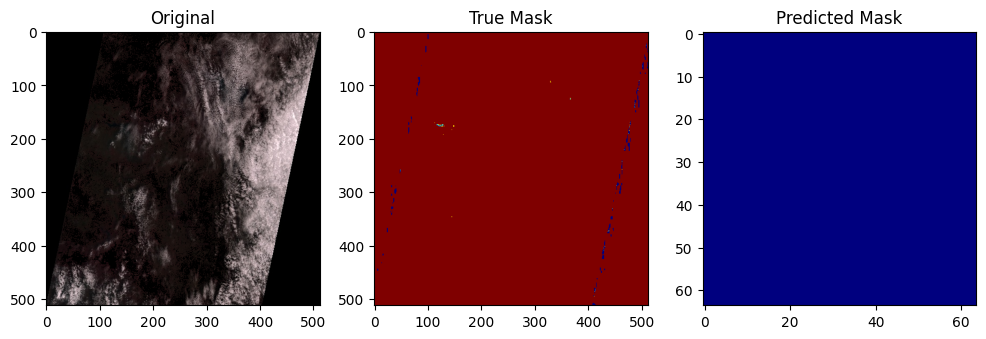

🟢 Accuracy: 99.41%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


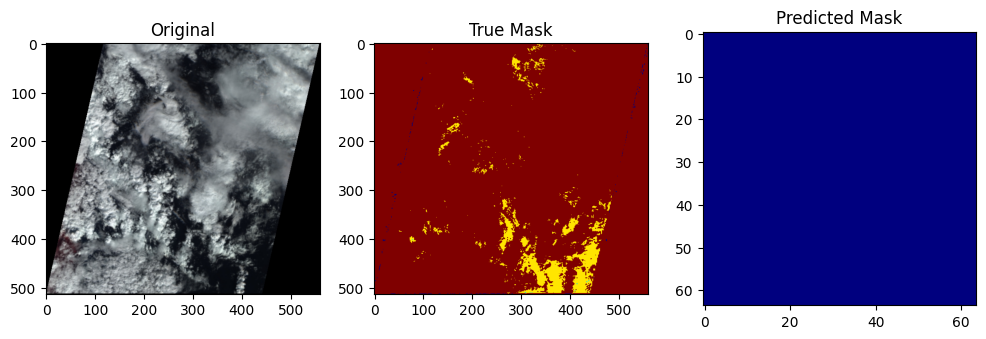

🟢 Accuracy: 95.63%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


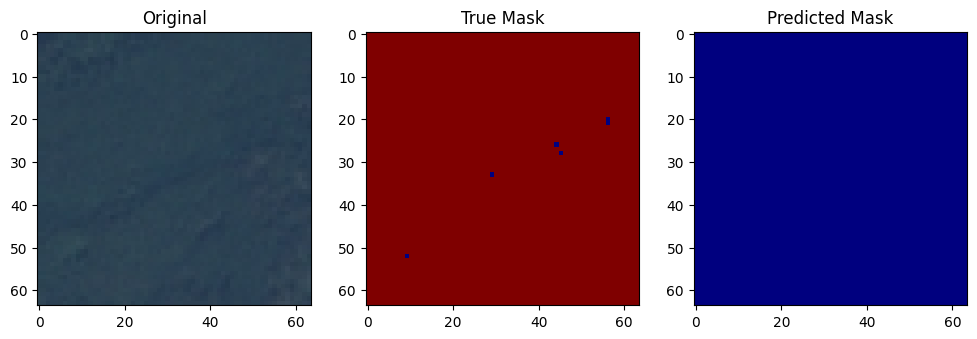

🟢 Accuracy: 0.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


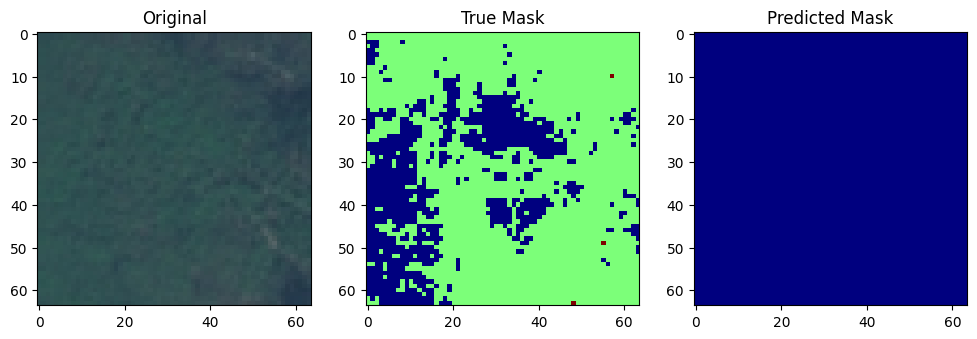

🟢 Accuracy: 0.07%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


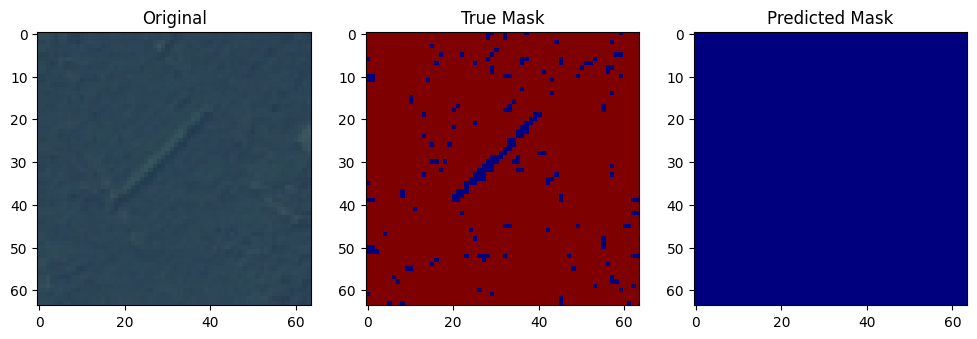

🟢 Accuracy: 0.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


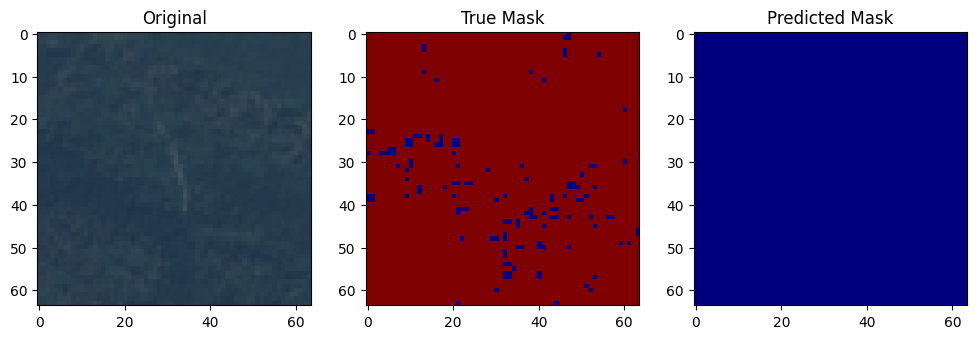

🟢 Accuracy: 0.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


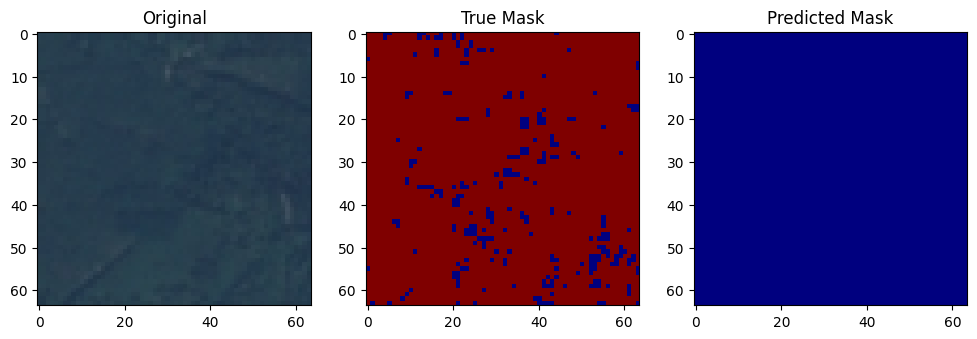

🟢 Accuracy: 0.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


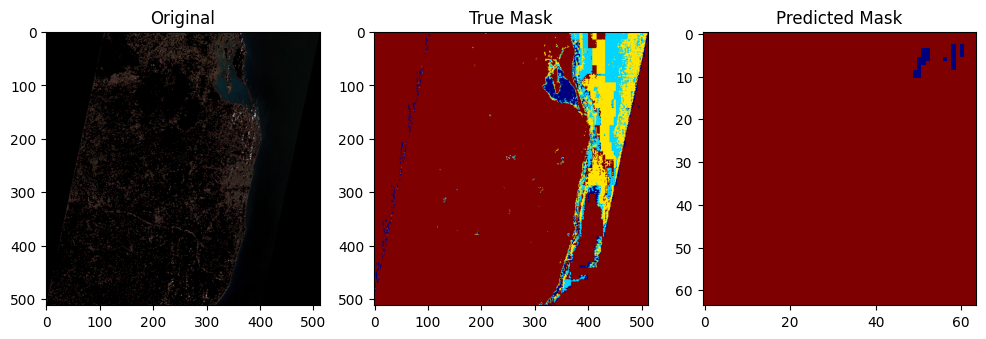

🟢 Accuracy: 85.52%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


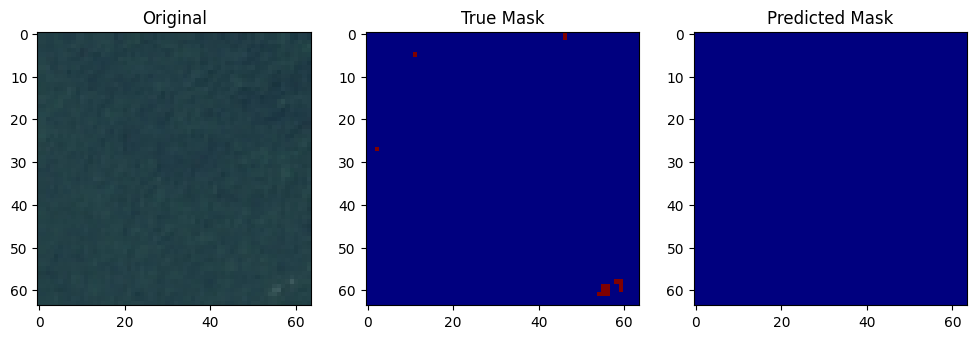

🟢 Accuracy: 0.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


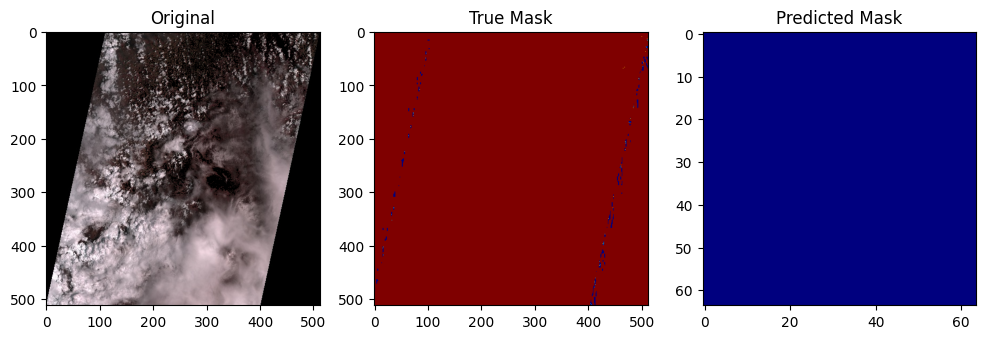

🟢 Accuracy: 99.24%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


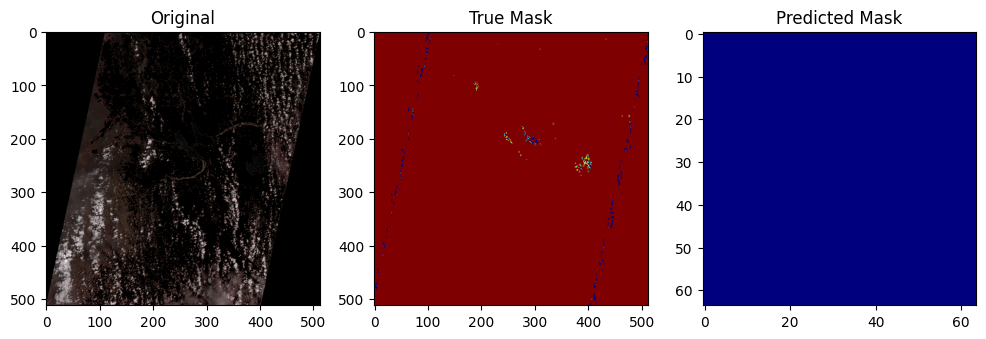

🟢 Accuracy: 98.88%


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

# ------------------- Load & Preprocess -------------------
def load_image(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def pseudo_ndvi(img):
    red = img[:, :, 0].astype(float)
    nir = img[:, :, 1].astype(float)  # Simulated NIR using green
    ndvi = (nir - red) / (nir + red + 1e-6)
    return ndvi

def generate_mask(ndvi):
    mask = np.zeros_like(ndvi, dtype=np.uint8)
    mask[ndvi > 0.4] = 0        # Forest
    mask[(ndvi > 0.25) & (ndvi <= 0.4)] = 1  # Grassland
    mask[(ndvi > 0.1) & (ndvi <= 0.25)] = 2  # Shrub
    mask[ndvi <= 0.1] = 3       # Non-veg
    return mask

# ------------------- Cloud Masking -------------------
# Forest image filenames that should not undergo cloud masking
forest_images = ['1.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']

def cloud_masking(img, threshold=0.35, img_name=None):
    """
    This function detects clouds using NDSI and returns a cloud mask.
    Cloud pixels are marked as 1, non-cloud pixels as 0.
    A moderate threshold results in medium cloud masking.
    Cloud masking will be skipped for forest images.
    """
    if img_name in forest_images:
        print(f"Skipping cloud masking for forest image: {img_name}")
        return np.zeros_like(img[:, :, 0])  # Return an empty cloud mask (no clouds) for forest images

    # For non-forest images, apply cloud masking
    blue = img[:, :, 0].astype(float)
    swir = img[:, :, 2].astype(float)  # Short-Wave Infrared (SWIR)
    ndsi = (blue - swir) / (blue + swir + 1e-6)  # NDSI calculation

    # Medium threshold for cloud detection
    cloud_mask = np.where(ndsi > threshold, 1, 0)  # Clouds if NDSI > threshold
    return cloud_mask

def apply_cloud_mask(img, cloud_mask):
    """
    Apply the cloud mask to the image by setting cloud pixels to zero (or other masking method).
    """
    img_masked = img.copy()
    img_masked[cloud_mask == 1] = 0  # Set cloud pixels to black (or any other method)
    return img_masked

# ------------------- Patching -------------------
def patchify(img, mask, size):
    patches = []
    mask_patches = []
    h, w = img.shape[:2]
    for i in range(0, h - size + 1, size):
        for j in range(0, w - size + 1, size):
            patch = img[i:i+size, j:j+size]
            m_patch = mask[i:i+size, j:j+size]
            patches.append(patch)
            mask_patches.append(m_patch)
    return patches, mask_patches

# ------------------- Load All Images -------------------
image_dir = '/content/'  # Update if needed
mask_dir = '/content/'   # Directory where the true masks are stored
patch_size = 64
img_patches, mask_patches = [], []

# Assuming true masks are uploaded in the same directory
true_masks = ['Screenshot 2025-04-13 051830.png', 'Screenshot 2025-04-13 053052.png',
              'Screenshot 2025-04-13 053034.png', 'Screenshot 2025-04-13 053042.png']  # Update accordingly

# Process all images
for fname in os.listdir(image_dir):
    if fname.endswith('.jpg'):
        img = load_image(os.path.join(image_dir, fname))

        # Apply cloud masking if not a forest image
        cloud_mask = cloud_masking(img, img_name=fname)
        img = apply_cloud_mask(img, cloud_mask)  # Apply cloud mask to the image

        ndvi = pseudo_ndvi(img)
        mask = generate_mask(ndvi)

        img_patches_temp, mask_patches_temp = patchify(img, mask, patch_size)
        img_patches.extend(img_patches_temp)
        mask_patches.extend(mask_patches_temp)

# ------------------- Prepare Data -------------------
X = np.array(img_patches) / 255.0
y = to_categorical(np.array(mask_patches), num_classes=4)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------- Model (U-Net Small) -------------------
def build_unet(input_shape=(64, 64, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    u1 = layers.UpSampling2D()(c3)
    m1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(m1)

    u2 = layers.UpSampling2D()(c4)
    m2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(m2)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c5)
    return models.Model(inputs, outputs)

model = build_unet()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ------------------- Train -------------------
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=16)

# ------------------- Predict & Visualize -------------------
def predict_and_show(img_path):
    img_name = os.path.basename(img_path)  # Get the image file name
    img = load_image(img_path)

    # Apply cloud masking conditionally
    cloud_mask = cloud_masking(img, img_name=img_name)
    img = apply_cloud_mask(img, cloud_mask)  # Apply cloud mask to the image

    # Get NDVI and true mask
    ndvi = pseudo_ndvi(img)
    mask = generate_mask(ndvi)

    # Prepare the image patch for model prediction
    input_patch = cv2.resize(img, (64, 64)) / 255.0
    input_patch = np.expand_dims(input_patch, axis=0)

    # Predict the mask using the model
    pred = model.predict(input_patch)[0]
    pred_mask = np.argmax(pred, axis=-1)

    # Visualize the original image, true mask, and predicted mask
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Original")
    plt.subplot(1,3,2); plt.imshow(mask, cmap='jet'); plt.title("True Mask")
    plt.subplot(1,3,3); plt.imshow(pred_mask, cmap='jet'); plt.title("Predicted Mask")
    plt.show()

    # Calculate accuracy (comparison with resized mask)
    acc = np.sum(pred_mask == cv2.resize(mask, (64, 64))) / (64 * 64)
    print(f"🟢 Accuracy: {acc*100:.2f}%")

# ------------------- Test on All Images -------------------
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')]

for img_path in image_paths:
    predict_and_show(img_path)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 15s 590ms/step - accuracy: 0.4679 - loss: 1.3483 - val_accuracy: 0.9334 - val_loss: 0.3389
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 443ms/step - accuracy: 0.9318 - loss: 0.5083 - val_accuracy: 0.9437 - val_loss: 0.2512
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 450ms/step - accuracy: 0.9426 - loss: 0.2358 - val_accuracy: 0.9438 - val_loss: 0.2178
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 543ms/step - accuracy: 0.9315 - loss: 0.2219 - val_accuracy: 0.9439 - val_loss: 0.1945
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 458ms/step - accuracy: 0.9529 - loss: 0.1459 - val_accuracy: 0.9439 - val_loss: 0.1733
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 417ms/step - accuracy: 0.9414 - loss: 0.1499 - val_accuracy: 0.9439 - val_loss: 0.1637
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 463ms/step - accuracy: 0.9516 - loss: 0.1201 - val_accuracy: 0.9441 - val_loss: 0.1670
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 544ms/step - accuracy: 0.9447 - loss: 0.1530 - val_accura

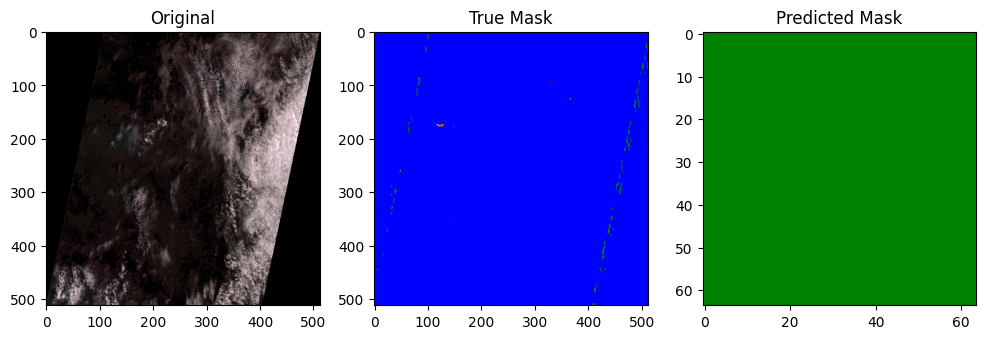

🟢 Accuracy: 99.41%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


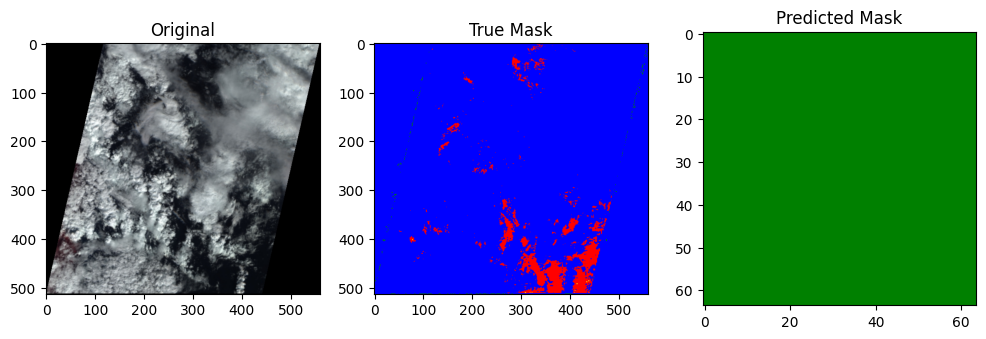

🟢 Accuracy: 95.63%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


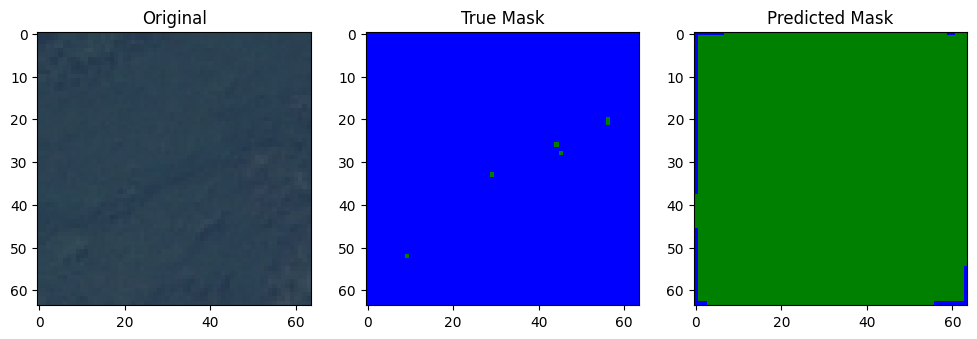

🟢 Accuracy: 97.85%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


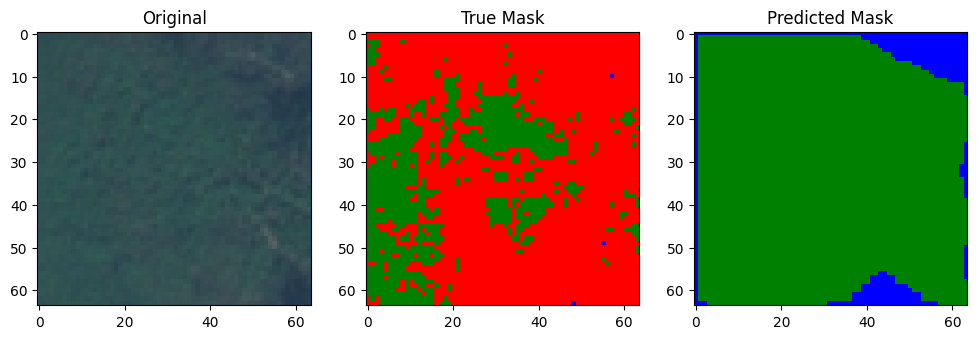

🟢 Accuracy: 64.97%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


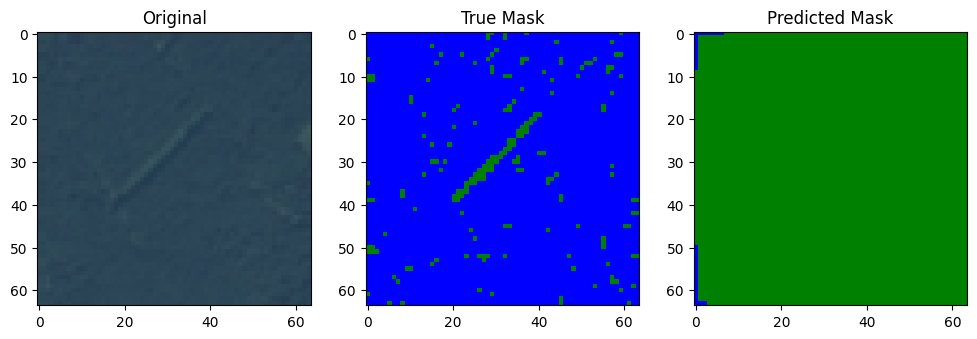

🟢 Accuracy: 94.56%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


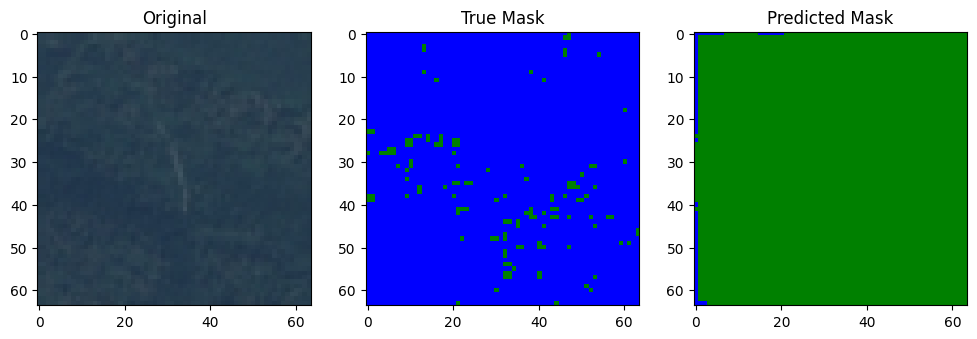

🟢 Accuracy: 95.21%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


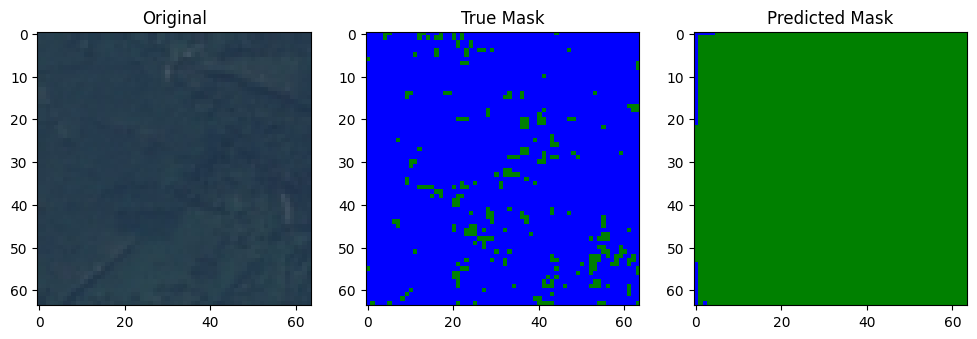

🟢 Accuracy: 92.70%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


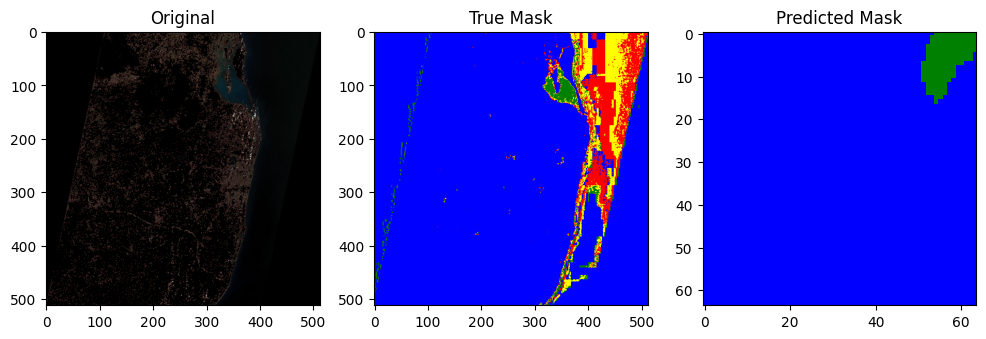

🟢 Accuracy: 87.04%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


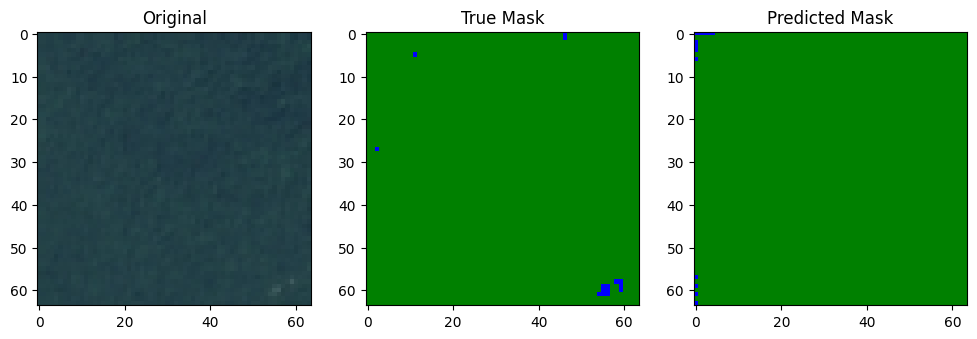

🟢 Accuracy: 0.37%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


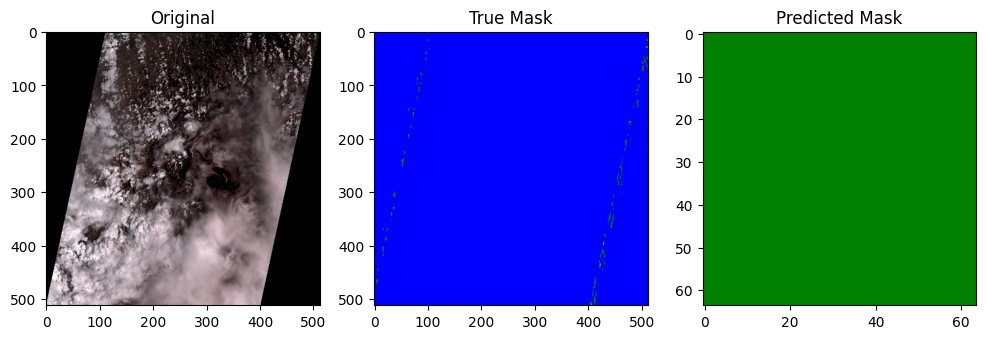

🟢 Accuracy: 99.24%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


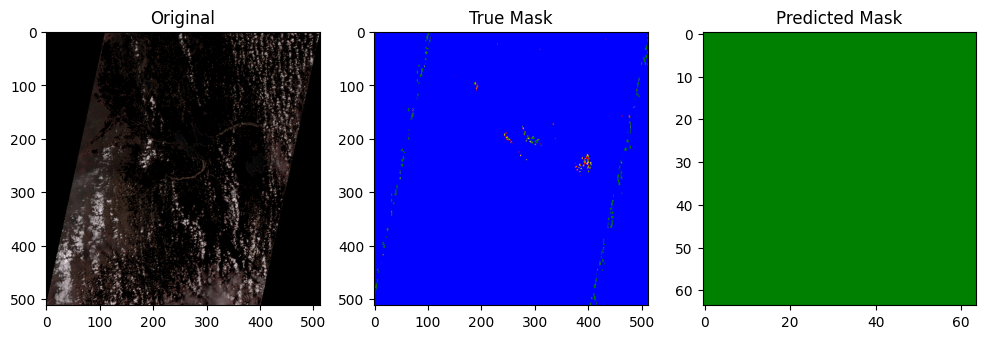

🟢 Accuracy: 98.88%


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import matplotlib.colors as mcolors

# ------------------- Load & Preprocess -------------------
def load_image(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def pseudo_ndvi(img):
    red = img[:, :, 0].astype(float)
    nir = img[:, :, 1].astype(float)  # Simulated NIR using green
    ndvi = (nir - red) / (nir + red + 1e-6)
    return ndvi

def generate_mask(ndvi):
    mask = np.zeros_like(ndvi, dtype=np.uint8)
    mask[ndvi > 0.4] = 0        # Forest
    mask[(ndvi > 0.25) & (ndvi <= 0.4)] = 1  # Grassland
    mask[(ndvi > 0.1) & (ndvi <= 0.25)] = 2  # Shrub
    mask[ndvi <= 0.1] = 3       # Non-veg
    return mask

# ------------------- Cloud Masking -------------------
forest_images = ['1.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']

def cloud_masking(img, threshold=0.35, img_name=None):
    if img_name in forest_images:
        print(f"Skipping cloud masking for forest image: {img_name}")
        return np.zeros_like(img[:, :, 0])  # Return an empty cloud mask (no clouds) for forest images

    blue = img[:, :, 0].astype(float)
    swir = img[:, :, 2].astype(float)  # Short-Wave Infrared (SWIR)
    ndsi = (blue - swir) / (blue + swir + 1e-6)  # NDSI calculation

    cloud_mask = np.where(ndsi > threshold, 1, 0)  # Clouds if NDSI > threshold
    return cloud_mask

def apply_cloud_mask(img, cloud_mask):
    img_masked = img.copy()
    img_masked[cloud_mask == 1] = 0  # Set cloud pixels to black (or any other method)
    return img_masked

# ------------------- Patching -------------------
def patchify(img, mask, size):
    patches = []
    mask_patches = []
    h, w = img.shape[:2]
    for i in range(0, h - size + 1, size):
        for j in range(0, w - size + 1, size):
            patch = img[i:i+size, j:j+size]
            m_patch = mask[i:i+size, j:j+size]
            patches.append(patch)
            mask_patches.append(m_patch)
    return patches, mask_patches

# ------------------- Load All Images -------------------
image_dir = '/content/'  # Update if needed
mask_dir = '/content/'   # Directory where the true masks are stored
patch_size = 64
img_patches, mask_patches = [], []

# Assuming true masks are uploaded in the same directory
true_masks = ['Screenshot 2025-04-13 051830.png', 'Screenshot 2025-04-13 053052.png',
              'Screenshot 2025-04-13 053034.png', 'Screenshot 2025-04-13 053042.png']  # Update accordingly

for fname in os.listdir(image_dir):
    if fname.endswith('.jpg'):
        img = load_image(os.path.join(image_dir, fname))

        # Apply cloud masking if not a forest image
        cloud_mask = cloud_masking(img, img_name=fname)
        img = apply_cloud_mask(img, cloud_mask)  # Apply cloud mask to the image

        ndvi = pseudo_ndvi(img)
        mask = generate_mask(ndvi)

        img_patches_temp, mask_patches_temp = patchify(img, mask, patch_size)
        img_patches.extend(img_patches_temp)
        mask_patches.extend(mask_patches_temp)

# ------------------- Prepare Data -------------------
X = np.array(img_patches) / 255.0
y = to_categorical(np.array(mask_patches), num_classes=4)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------- Model (U-Net Small) -------------------
def build_unet(input_shape=(64, 64, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    u1 = layers.UpSampling2D()(c3)
    m1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(m1)

    u2 = layers.UpSampling2D()(c4)
    m2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(m2)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c5)
    return models.Model(inputs, outputs)

model = build_unet()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ------------------- Train -------------------
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=16)

# ------------------- Custom Color Map -------------------
# Custom color mapping for the masks
# Define colors for each class: Forest (Green), Grassland (Yellow), Shrubs (Red), Non-Veg (Blue)
colors = [(0, 'green'), (1, 'yellow'), (2, 'red'), (3, 'blue')]  # Define colors for each class
cmap = mcolors.ListedColormap([color[1] for color in colors])

# ------------------- Predict & Visualize -------------------
def predict_and_show(img_path):
    img_name = os.path.basename(img_path)  # Get the image file name
    img = load_image(img_path)

    # Apply cloud masking conditionally
    cloud_mask = cloud_masking(img, img_name=img_name)
    img = apply_cloud_mask(img, cloud_mask)  # Apply cloud mask to the image

    # Get NDVI and true mask
    ndvi = pseudo_ndvi(img)
    mask = generate_mask(ndvi)

    # Prepare the image patch for model prediction
    input_patch = cv2.resize(img, (64, 64)) / 255.0
    input_patch = np.expand_dims(input_patch, axis=0)

    # Predict the mask using the model
    pred = model.predict(input_patch)[0]
    pred_mask = np.argmax(pred, axis=-1)

    # Visualize the original image, true mask, and predicted mask
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Original")
    plt.subplot(1,3,2); plt.imshow(mask, cmap=cmap); plt.title("True Mask")
    plt.subplot(1,3,3); plt.imshow(pred_mask, cmap=cmap); plt.title("Predicted Mask")
    plt.show()

    # Calculate accuracy (comparison with resized mask)
    acc = np.sum(pred_mask == cv2.resize(mask, (64, 64))) / (64 * 64)
    print(f"🟢 Accuracy: {acc*100:.2f}%")

# ------------------- Test on All Images -------------------
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')]

for img_path in image_paths:
    predict_and_show(img_path)


In [ ]:
# ------------------- Predict & Visualize -------------------
def predict_and_show(img_path):
    img_name = os.path.basename(img_path)  # Get the image file name
    img = load_image(img_path)

    # Apply cloud masking conditionally
    cloud_mask = cloud_masking(img, img_name=img_name)
    img = apply_cloud_mask(img, cloud_mask)  # Apply cloud mask to the image

    # Get NDVI and true mask
    ndvi = pseudo_ndvi(img)
    mask = generate_mask(ndvi)

    # Prepare the image patch for model prediction
    input_patch = cv2.resize(img, (64, 64)) / 255.0
    input_patch = np.expand_dims(input_patch, axis=0)

    # Predict the mask using the model
    pred = model.predict(input_patch)[0]
    pred_mask = np.argmax(pred, axis=-1)

    # Debug: Check the mask values
    print("True mask values:", np.unique(mask))  # Check unique values in the true mask
    print("Predicted mask values:", np.unique(pred_mask))  # Check unique values in the predicted mask

    # Visualize the original image, true mask, and predicted mask
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Original")
    plt.subplot(1,3,2); plt.imshow(mask, cmap=cmap); plt.title("True Mask")
    plt.subplot(1,3,3); plt.imshow(pred_mask, cmap=cmap); plt.title("Predicted Mask")
    plt.show()

    # Calculate accuracy (comparison with resized mask)
    acc = np.sum(pred_mask == cv2.resize(mask, (64, 64))) / (64 * 64)
    print(f"🟢 Accuracy: {acc*100:.2f}%")


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 429ms/step - accuracy: 0.7284 - loss: 1.1258 - val_accuracy: 0.9439 - val_loss: 0.3177
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 517ms/step - accuracy: 0.9385 - loss: 0.3614 - val_accuracy: 0.9439 - val_loss: 0.2626
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 427ms/step - accuracy: 0.9383 - loss: 0.2306 - val_accuracy: 0.9439 - val_loss: 0.2013
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 404ms/step - accuracy: 0.9580 - loss: 0.1503 - val_accuracy: 0.9439 - val_loss: 0.1722
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 434ms/step - accuracy: 0.9439 - loss: 0.1632 - val_accuracy: 0.9439 - val_loss: 0.1649
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 529ms/step - accuracy: 0.9434 - loss: 0.1540 - val_accuracy: 0.9439 - val_loss: 0.1507
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 411ms/step - accuracy: 0.9405 - loss: 0.1281 - val_accuracy: 0.9439 - val_loss: 0.1439
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 438ms/step - accuracy: 0.9426 - loss: 0.1309 - val_accuracy

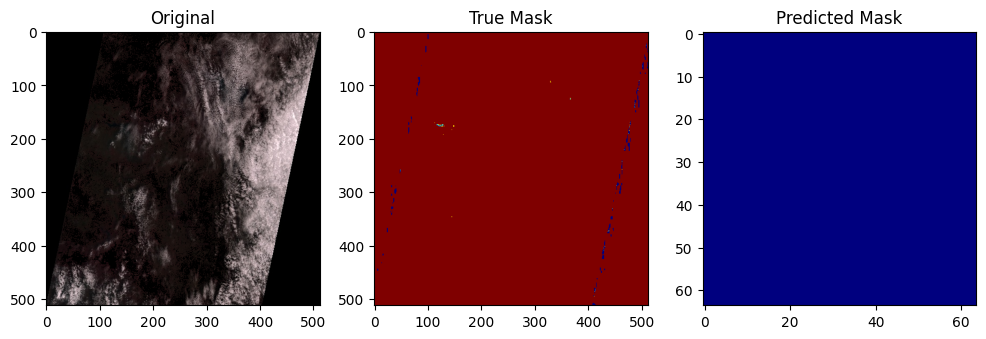

🟢 Accuracy: 99.41%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
True mask values: [0 1 2 3]
Predicted mask values: [3]


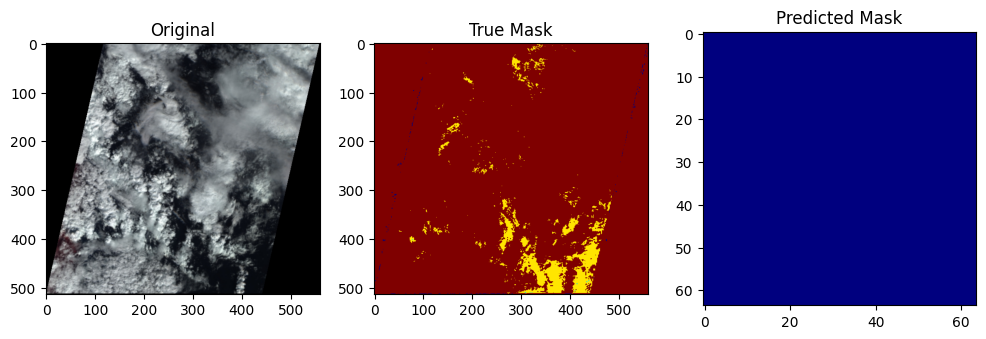

🟢 Accuracy: 95.63%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
True mask values: [1 2]
Predicted mask values: [2 3]


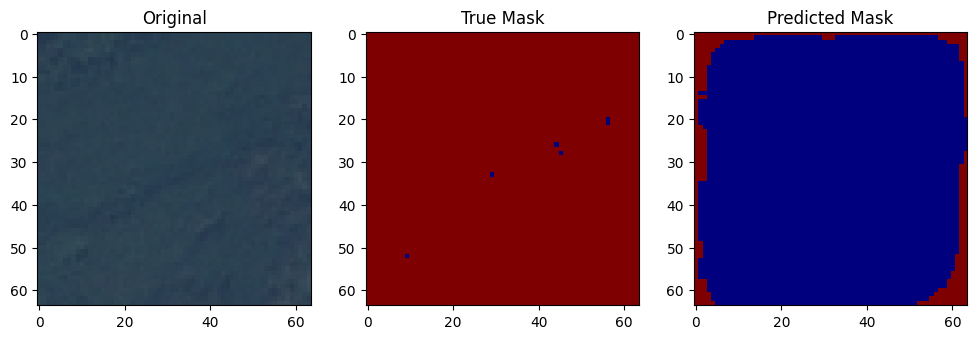

🟢 Accuracy: 90.82%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
True mask values: [1 2 3]
Predicted mask values: [2 3]


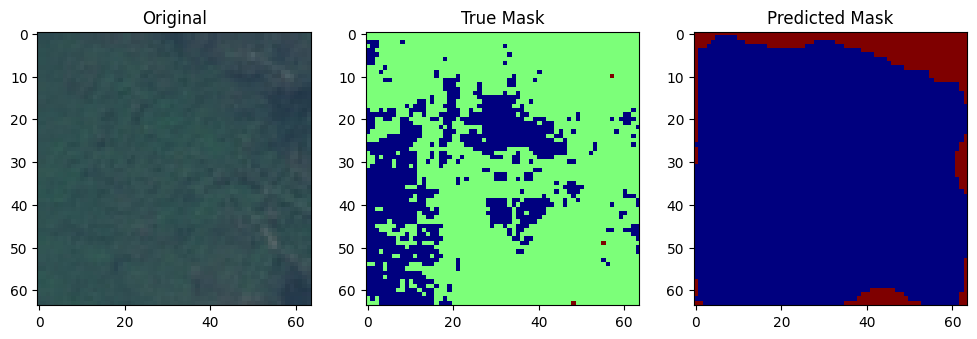

🟢 Accuracy: 63.21%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
True mask values: [1 2]
Predicted mask values: [2 3]


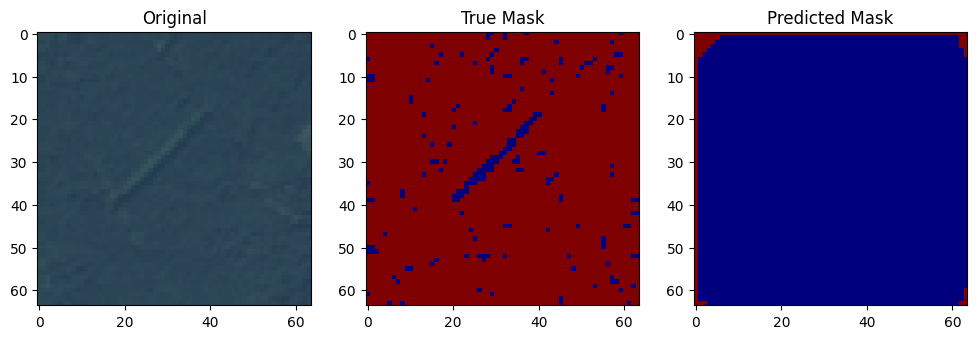

🟢 Accuracy: 91.70%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
True mask values: [1 2]
Predicted mask values: [2 3]


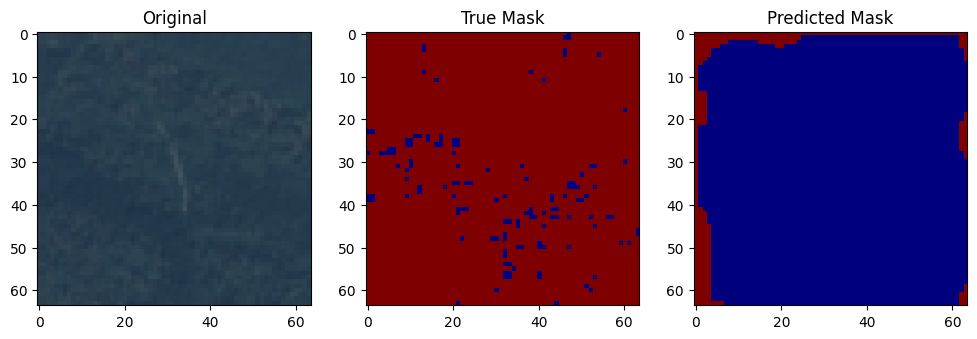

🟢 Accuracy: 89.48%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
True mask values: [1 2]
Predicted mask values: [2 3]


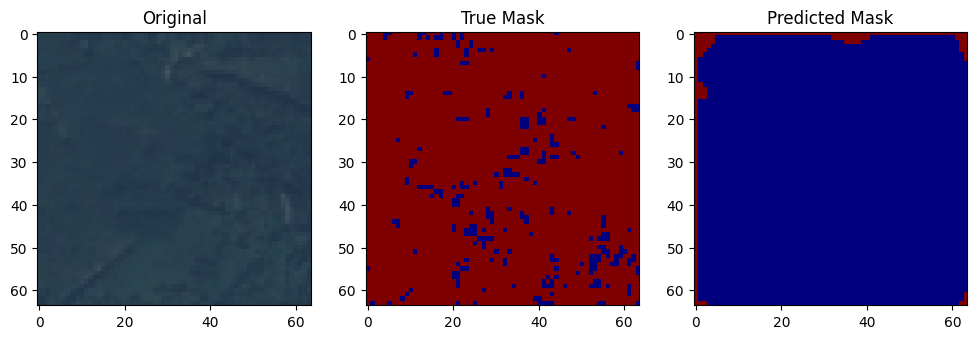

🟢 Accuracy: 89.50%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
True mask values: [0 1 2 3]
Predicted mask values: [2 3]


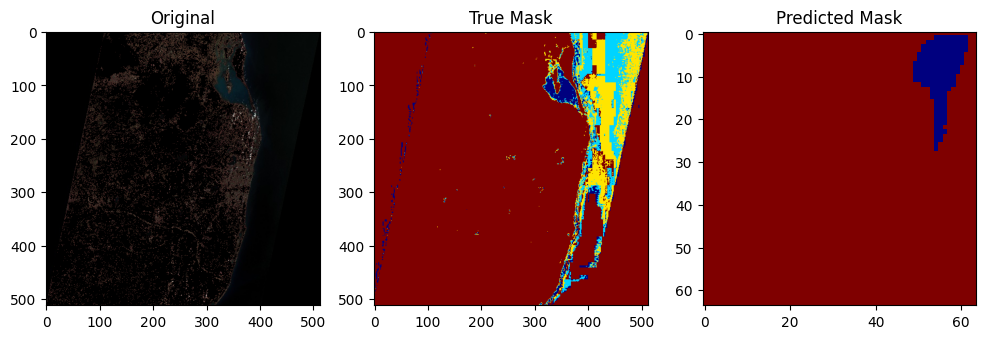

🟢 Accuracy: 87.48%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
True mask values: [1 2]
Predicted mask values: [2 3]


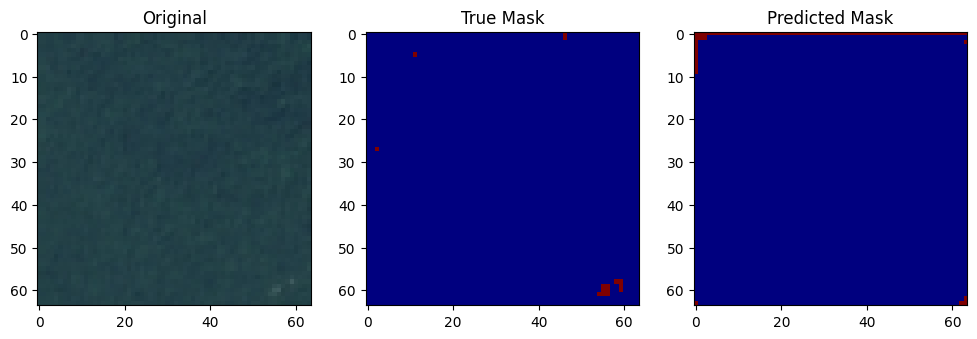

🟢 Accuracy: 0.34%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
True mask values: [0 1 2 3]
Predicted mask values: [3]


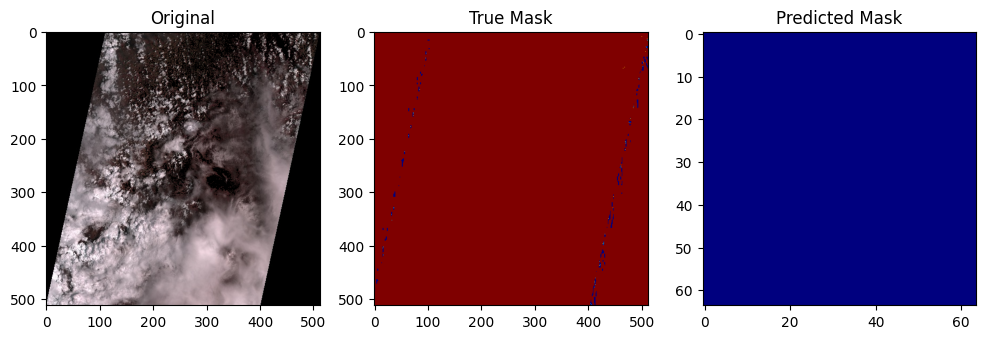

🟢 Accuracy: 99.24%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
True mask values: [0 1 2 3]
Predicted mask values: [3]


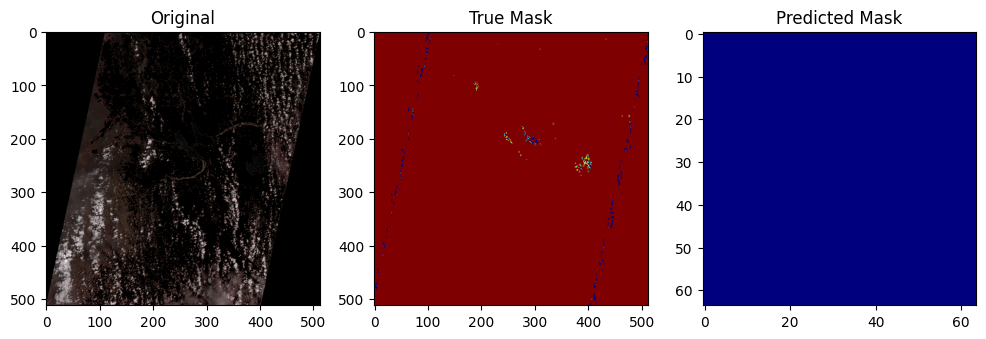

🟢 Accuracy: 98.88%


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

# ------------------- Load & Preprocess -------------------
def load_image(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def pseudo_ndvi(img):
    red = img[:, :, 0].astype(float)
    nir = img[:, :, 1].astype(float)  # Simulated NIR using green
    ndvi = (nir - red) / (nir + red + 1e-6)
    return ndvi

def generate_mask(ndvi):
    mask = np.zeros_like(ndvi, dtype=np.uint8)
    mask[ndvi > 0.4] = 0        # Forest
    mask[(ndvi > 0.25) & (ndvi <= 0.4)] = 1  # Grassland
    mask[(ndvi > 0.1) & (ndvi <= 0.25)] = 2  # Shrub
    mask[ndvi <= 0.1] = 3       # Non-veg
    return mask

# ------------------- Cloud Masking -------------------
# Forest image filenames that should not undergo cloud masking
forest_images = ['1.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg']

def cloud_masking(img, threshold=0.35, img_name=None):
    """
    This function detects clouds using NDSI and returns a cloud mask.
    Cloud pixels are marked as 1, non-cloud pixels as 0.
    A moderate threshold results in medium cloud masking.
    Cloud masking will be skipped for forest images.
    """
    if img_name in forest_images:
        print(f"Skipping cloud masking for forest image: {img_name}")
        return np.zeros_like(img[:, :, 0])  # Return an empty cloud mask (no clouds) for forest images

    # For non-forest images, apply cloud masking
    blue = img[:, :, 0].astype(float)
    swir = img[:, :, 2].astype(float)  # Short-Wave Infrared (SWIR)
    ndsi = (blue - swir) / (blue + swir + 1e-6)  # NDSI calculation

    # Medium threshold for cloud detection
    cloud_mask = np.where(ndsi > threshold, 1, 0)  # Clouds if NDSI > threshold
    return cloud_mask

def apply_cloud_mask(img, cloud_mask):
    """
    Apply the cloud mask to the image by setting cloud pixels to zero (or other masking method).
    """
    img_masked = img.copy()
    img_masked[cloud_mask == 1] = 0  # Set cloud pixels to black (or any other method)
    return img_masked

# ------------------- Patching -------------------
def patchify(img, mask, size):
    patches = []
    mask_patches = []
    h, w = img.shape[:2]
    for i in range(0, h - size + 1, size):
        for j in range(0, w - size + 1, size):
            patch = img[i:i+size, j:j+size]
            m_patch = mask[i:i+size, j:j+size]
            patches.append(patch)
            mask_patches.append(m_patch)
    return patches, mask_patches

# ------------------- Load All Images -------------------
image_dir = '/content/'  # Update if needed
mask_dir = '/content/'   # Directory where the true masks are stored
patch_size = 64
img_patches, mask_patches = [], []

# Assuming true masks are uploaded in the same directory
true_masks = ['Screenshot 2025-04-13 051830.png', 'Screenshot 2025-04-13 053052.png',
              'Screenshot 2025-04-13 053034.png', 'Screenshot 2025-04-13 053042.png']  # Update accordingly

# Process all images
for fname in os.listdir(image_dir):
    if fname.endswith('.jpg'):
        img = load_image(os.path.join(image_dir, fname))

        # Apply cloud masking if not a forest image
        cloud_mask = cloud_masking(img, img_name=fname)
        img = apply_cloud_mask(img, cloud_mask)  # Apply cloud mask to the image

        ndvi = pseudo_ndvi(img)
        mask = generate_mask(ndvi)

        img_patches_temp, mask_patches_temp = patchify(img, mask, patch_size)
        img_patches.extend(img_patches_temp)
        mask_patches.extend(mask_patches_temp)

# ------------------- Prepare Data -------------------
X = np.array(img_patches) / 255.0
y = to_categorical(np.array(mask_patches), num_classes=4)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# ------------------- Model (U-Net Small) -------------------
def build_unet(input_shape=(64, 64, 3), num_classes=4):
    inputs = layers.Input(shape=input_shape)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)

    u1 = layers.UpSampling2D()(c3)
    m1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(m1)

    u2 = layers.UpSampling2D()(c4)
    m2 = layers.concatenate([u2, c1])
    c5 = layers.Conv2D(16, 3, activation='relu', padding='same')(m2)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c5)
    return models.Model(inputs, outputs)

model = build_unet()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# ------------------- Train -------------------
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=16)

# ------------------- Predict & Visualize -------------------
def predict_and_show(img_path):
    img_name = os.path.basename(img_path)  # Get the image file name
    img = load_image(img_path)

    # Apply cloud masking conditionally
    cloud_mask = cloud_masking(img, img_name=img_name)
    img = apply_cloud_mask(img, cloud_mask)  # Apply cloud mask to the image

    # Get NDVI and true mask
    ndvi = pseudo_ndvi(img)
    mask = generate_mask(ndvi)

    # Prepare the image patch for model prediction
    input_patch = cv2.resize(img, (64, 64)) / 255.0
    input_patch = np.expand_dims(input_patch, axis=0)

    # Predict the mask using the model
    pred = model.predict(input_patch)[0]
    pred_mask = np.argmax(pred, axis=-1)

    # Debug: Check the mask values
    print("True mask values:", np.unique(mask))  # Check unique values in the true mask
    print("Predicted mask values:", np.unique(pred_mask))  # Check unique values in the predicted mask

    # Visualize the original image, true mask, and predicted mask
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Original")
    plt.subplot(1,3,2); plt.imshow(mask, cmap='jet'); plt.title("True Mask")
    plt.subplot(1,3,3); plt.imshow(pred_mask, cmap='jet'); plt.title("Predicted Mask")
    plt.show()

    # Calculate accuracy (comparison with resized mask)
    acc = np.sum(pred_mask == cv2.resize(mask, (64, 64))) / (64 * 64)
    print(f"🟢 Accuracy: {acc*100:.2f}%")

# ------------------- Test on All Images -------------------
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.jpg')]

for img_path in image_paths:
    predict_and_show(img_path)
